# LSI flood event 

# UPDATE with UTS Period from: 2019/12/3 - 2019/12/27

A large rainfall event resulting in spilling at a number of hydro stations in the South Island throughout November and December 2019.  A UTS was alleged on the 12 December 2019.  This notebook provides some of the analysis performed by the market monitoring team into this event.

We first look at South Island hydro generation spill data provided by both Meridian and Contact.  

### vSPD simulations

We started our UTS analysis by using vSPD to model potential alternative pricing scenarios had offers by the LSI generators been lower.  We decided to only alter LSI generation offer prices (not quantities) and we only set offer prices if, at the same time, the hydro generator had recorded hydro spill.  

Our initial analysis did this for all generators, ignoring physical and resource constraint limits that the LSI generators must take into account.  As described further below, we then attempted to take into account some of the resource and hydrological constraint limits faced by the LSI generators.  

Our first vSPD modelling was conducted by splitting the time period into seven sequential time periods (as illustrated below) with different combinations of hydro stations spilling.  This made simulating each period relatively straight-forward by setting offer prices for the generators spilling during each period. 

The seven time periods are:

  - vSPD run1 (~6 days and ~13 days) 2019-11-09 -> 2019-12-02 MAN spilling
  - vSPD run2 (~4 days) 2019-11-15 -> 2019-11-18) MAN/AVI/WTK spilling
  - vSPD run3 (~5 days) 2019-12-03 -> 2019-12-07 MAN/CYD/ROX/BEN/AVI/WTK spilling
  - vSPD run4 (~20 days) 2019-12-08 -> 2019-12-27 MAN/OHA/OHB/OHC/BEN/AVI/WTK/ROX/CYD all spilling
  - vSPD run5 (~3 days) 2019-12-28 -> 2019-12-30 MAN/OHA/OHB/OHC/BEN/AVI/WTK all spilling
  - vSPD run6 (~6 days) 2019-12-31 -> 2020-01-05 MAN/BEN/AVI/WTK spilling
  - vSPD run7 (~10 days) 2020-01-06 -> 2020-01-16 MAN/AVI/WTK spilling



In [1]:
import pandas as pd
%pylab inline
from datetime import date, datetime, time, timedelta

Populating the interactive namespace from numpy and matplotlib


In [85]:
# get some nice colours and define better legend and plot formatting...

c_p = {'rd2': (0.9647058823529412, 0.5450980392156862, 0.6352941176470588), 'yl1': (1.0, 0.7294117647058823, 0.17647058823529413), 'gy2': (0.9098039215686274, 0.9098039215686274, 0.9098039215686274), 'bl2': (0.7176470588235294, 0.8901960784313725, 0.9725490196078431), 'yl2': (0.984313725490196, 0.8196078431372549, 0.5450980392156862), 'br1': (0.32941176470588235, 0.0, 0.0), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'rd1': (0.9294117647058824, 0.09019607843137255, 0.27058823529411763), 'gy1': (0.8235294117647058, 0.8235294117647058, 0.8235294117647058), 'br2': (0.6627450980392157, 0.5019607843137255, 0.5019607843137255)}
c_s = {'og1': (0.8235294117647058, 0.38823529411764707, 0.10196078431372549), 'yl1': (0.803921568627451, 0.8156862745098039, 0.0), 'or1': (1.0, 0.4823529411764706, 0.0), 'pp1': (0.27058823529411763, 0.1803921568627451, 0.6745098039215687), 'mv1': (0.0, 0.4588235294117647, 0.4235294117647059), 'rd2': (0.8470588235294118, 0.5882352941176471, 0.5019607843137255), 'pr1': (0.803921568627451, 0.34901960784313724, 1.0), 'pk2': (1.0, 0.7372549019607844, 0.8313725490196079), 'gr1': (0.00784313725490196, 0.4666666666666667, 0.2196078431372549), 'or2': (1.0, 0.7372549019607844, 0.5019607843137255), 'mv2': (0.5019607843137255, 0.7254901960784313, 0.7098039215686275), 'pp2': (0.6862745098039216, 0.6431372549019608, 0.7411764705882353), 'gn1': (0.3803921568627451, 0.7372549019607844, 0.22745098039215686), 'bu1': (0.0, 0.5568627450980392, 1.0), 'bl2': (0.5254901960784314, 0.7372549019607844, 0.8392156862745098), 'ge1': (0.0, 0.7019607843137254, 0.6196078431372549), 'yl2': (0.8980392156862745, 0.9058823529411765, 0.5019607843137255), 'bu2': (0.5019607843137255, 0.7725490196078432, 1.0), 'ge2': (0.5019607843137255, 0.8470588235294118, 0.807843137254902), 'rd1': (0.7019607843137254, 0.18823529411764706, 0.0), 'gy1': (0.5843137254901961, 0.5843137254901961, 0.5843137254901961), 'og2': (0.8901960784313725, 0.6901960784313725, 0.5490196078431373), 'gy2': (0.788235294117647, 0.788235294117647, 0.788235294117647), 'be2': (0.8862745098039215, 0.9490196078431372, 0.984313725490196), 'pk1': (1.0, 0.3411764705882353, 0.9607843137254902), 'be1': (0.7803921568627451, 0.9019607843137255, 0.9803921568627451), 'gr2': (0.5019607843137255, 0.7294117647058823, 0.7098039215686275), 'bl1': (0.058823529411764705, 0.4823529411764706, 0.6862745098039216), 'gn2': (0.6862745098039216, 0.8666666666666667, 0.611764705882353), 'pr2': (0.8980392156862745, 0.6705882352941176, 1.0)}

def colours():
    mpl.rcParams['axes.prop_cycle'] = cycler('color', [c_p['br1'], c_p['br2'],
        c_p['bl1'], c_p['bl2'], c_p['yl1'], c_p['yl2'], c_p['rd1'], c_p['rd2'],
        c_p['gy1'], c_p['gy2'], c_s['pp1'], c_s['pp2'], c_s['pr1'], c_s['pr2'],
        c_s['gr1'], c_s['gr2'], c_s['gn1'], c_s['gn2'], c_s['pk1'], c_s['pk2'],
        c_s['yl1'], c_s['yl2'], c_s['mv1'], c_s['mv2']])

def legend_format(ax, cols=4, xpos=-0.021, ypos=-0.15, **kwargs):
    """Place legend outside of plot"""
    ax.legend(loc=3,
              bbox_to_anchor=(xpos, ypos),
              ncol=cols,
              frameon=False, **kwargs)

def plot_formatting(ax, rot=False, **kwargs):
    """A few tricks used for better looking plots"""
    ax.grid(b=True, which='major', color='k', linestyle='-',
            axis='y', alpha=0.6, clip_on=True, marker=None)
    ax.grid(b=False, axis='x', which='both')
    ax.set_frame_on(False)  # Remove plot frame
    ax.set_axisbelow(True)
    ax.xaxis.tick_bottom()
    plt.xticks(ax.get_xticks(), rotation=0, **kwargs)
    if rot:
        plt.xticks(ax.get_xticks(), rotation=90, **kwargs)
    else:
        plt.xticks(ax.get_xticks(), rotation=0, **kwargs) 

        
def plot_shading(ax, y_offset, run_text_list=['vSPD run 1', 'vSPD run 1', 'vSPD run 2', 'vSPD_run3',
                                             'vSPD run 4', 'vSPD_run5', 'vSPD_run6', 'vSPD run 7']):
    """shade charts with each timeperiod simulation"""
    ax.axvspan(datetime(2019, 11, 9, 10), datetime(2019,12,2,16), color=c_p['rd2'], alpha=0.2)
    ax.axvspan(datetime(2019, 11, 15, 8), datetime(2019,11,19,20), color=c_p['rd2'], alpha=0.2)
    ax.axvspan(datetime(2019, 12, 2, 16), datetime(2019,12,8), color=c_p['rd2'], alpha=0.4)
    ax.axvspan(datetime(2019, 12, 8), datetime(2019,12,28), color=c_p['rd2'], alpha=0.2)
    ax.axvspan(datetime(2019, 12, 28), datetime(2019,12,31), color=c_p['rd2'], alpha=0.4)
    ax.axvspan(datetime(2019, 12, 31), datetime(2020,1,6), color=c_p['rd2'], alpha=0.2)
    ax.axvspan(datetime(2020, 1, 6), datetime(2020,1,16), color=c_p['rd2'], alpha=0.4)
    ax.text(datetime(2019,11,10), y_offset, run_text_list[1])
    ax.text(datetime(2019,11,23), y_offset, run_text_list[1])
    ax.text(datetime(2019,11,15), y_offset, run_text_list[2])
    ax.text(datetime(2019,12,3), y_offset, run_text_list[3])
    ax.text(datetime(2019,12,16), y_offset, run_text_list[4])
    ax.text(datetime(2019,12,27), y_offset, run_text_list[5], rotation=0)
    ax.text(datetime(2020,1,1), y_offset, run_text_list[6])
    ax.text(datetime(2020,1,8), y_offset, run_text_list[7])

    
def UTS_period(ax):
    """UTS period plot shading..."""
    ax.axvspan(datetime(2019, 12, 3), datetime(2019, 12, 27), color=c_p['rd2'], alpha=0.4)

    
files={'brh_res': 'BranchResults_TP.csv',  # ignore brach results for speed + RAM issues
       'gen_res': 'OfferResults_TP.csv',
       'isl_res': 'IslandResults_TP.csv',
       'bid_res': 'BidResults_TP.csv', 'MNC_res': 'MNodeConstraintResults_TP.csv',
       'res_res': 'ReserveResults_TP.csv', 'nod_res': 'NodeResults_TP.csv',
       'bus_res': 'BusResults_TP.csv', 'brC_res': 'BrConstraintResults_TP.csv',
       'sum_res': 'SummaryResults_TP.csv', 'trd_res': 'TraderResults.csv',
       'sys_res': 'SystemResults.csv', 'scr_res': 'ScarcityResults_TP.csv'}
    
def vSPD_loader(path, case, files=files, csv=True):
    """load vSPD output data, save to parquet for speed"""
    output = {}
    if csv:
        for k, v in files.items():
            filename = path + case + '/' + case + '_' + v
            print('Loading: ' + filename)
            output[k] = pd.read_csv(filename, index_col=[0, 1], parse_dates=True)
            output[k].to_parquet(path + case + '_' + v[:-4] + '.parquet')
        return output
    else:  # use FAST parquet datafiles
        for k, v in files.items():
            filename = path + case + '_' + v[:-4] + '.parquet'
            print('Loading: ' + filename)
            df = pd.read_parquet(filename)
            df = df.groupby(level=[0, 1]).last()
            output[k] = df
        return output


def piece_together_vSPD_runs(run1, run2, run3, run4, run5, run6, run7, files):
    """given vSPD run data, output dictionary of dataframes pieced togther"""
    vSPDrun1Aa = "2019/11/9T10"     # start of MAN spilling (vSPD run 1A)
    vSPDrun1Ab = "2019/11/15T0730"  # end of   MAN spilling (vSPD run 1A)
    vSPDrun2a = "2019/11/15T08"     # start of MAN/AVI/WTK spilling (vSPD run 2)
    vSPDrun2b = "2019/11/19T1930"   # end of   MAN/AVI/WTK spilling (vSPD run 2)
    vSPDrun1Ba = "2019/11/19T2000"  # start of MAN spilling (vSPD run 1B)
    vSPDrun1Bb = "2019/12/02T1530"  # end of   MAN spilling (vSPD run 1B)
    vSPDrun3a = "2019/12/02T1600"   # start of MAN/CYD/ROX/BEN/AVI/WTK spilling (vSPD run 3)
    vSPDrun3b = "2019/12/07T2330"   # end of   MAN/CYD/ROX/BEN/AVI/WTK spilling (vSPD run 3)
    vSPDrun4a = "2019/12/08T0000"   # start of MAN/OHA/OHB/OHC/BEN/AVI/WTK/ROX/CYD spilling (vSPD run 4)
    vSPDrun4b = "2019/12/27T2330"   # end of   MAN/OHA/OHB/OHC/BEN/AVI/WTK/ROX/CYD spilling (vSPD run 4)
    vSPDrun5a = "2019/12/28T0000"   # start of MAN/OHA/OHB/OHC/BEN/AVI/WTK spilling (vSPD run 5)
    vSPDrun5b = "2019/12/30T2330"   # end of   MAN/OHA/OHB/OHC/BEN/AVI/WTK spilling (vSPD run 5)
    vSPDrun6a = "2019/12/31T0000"   # start of MAN/BEN/AVI/WTK spilling (vSPD run 6)
    vSPDrun6b = "2020/01/05T2330"   # end of   MAN/BEN/AVI/WTK spilling (vSPD run 6)
    vSPDrun7a = "2020/01/06T1600"   # start of MAN/AVI/WTK spilling (vSPD run 7)
    vSPDrun7b = "2020/01/16T2330"   # end of   MAN/AVI/WTK spilling (vSPD run 7)

    RUN1A = {}
    RUN2 = {}
    RUN1B = {}
    RUN3 = {}
    RUN4 = {}
    RUN5 = {}
    RUN6 = {}
    RUN7 = {}
    ALL_RUNS={}
    
    for k in files.keys():
        print(k)
        # main counterfactual vSPD run   
        RUN1A[k] = run1[k].unstack()[vSPDrun1Aa:vSPDrun1Ab].stack()
        RUN2[k] = run2[k].unstack()[vSPDrun2a:vSPDrun2b].stack()
        RUN1B[k] = run1[k].unstack()[vSPDrun1Ba:vSPDrun1Bb].stack()
        RUN3[k] = run3[k].unstack()[vSPDrun3a:vSPDrun3b].stack()
        RUN4[k] = run4[k].unstack()[vSPDrun4a:vSPDrun4b].stack()
        RUN5[k] = run5[k].unstack()[vSPDrun5a:vSPDrun5b].stack()
        RUN6[k] = run6[k].unstack()[vSPDrun6a:vSPDrun6b].stack()
        RUN7[k] = run7[k].unstack()[vSPDrun7a:vSPDrun7b].stack()

        # append timeseries runs together
        ALL_RUNS[k] = RUN1A[k].append(RUN2[k].append(RUN1B[k].append(RUN3[k].append(RUN4[k].append(RUN5[k].append(RUN6[k].append(RUN7[k])))))))  # orig vSPD counterfactual run result
        
    return ALL_RUNS


def get_hvdc_flow(df):
    """given branch flow datafram return HVDC flow"""
    BEN_HAY_BC = df['brh_res']['Flow (MW) (From->To)'].unstack().loc[:, ['BEN_HAY2.1', 'BEN_HAY1.1']].sum(axis=1)
    HAY_BEN_BC = df['brh_res']['Flow (MW) (From->To)'].unstack().loc[:, ['HAY_BEN2.1', 'HAY_BEN1.1']].sum(axis=1)
    df = (BEN_HAY_BC-HAY_BEN_BC)
    return df


def calc_diff_sys_cost(bc, run):
    """given basecase vSPD run and pieced together run, return total differnce in System Load cost"""
    bc_sys_res = bc['sys_res'].sort_index().reset_index(level=1, drop=True)
    run_sys_res = run['sys_res'].sort_index().reset_index(level=1, drop=True)
    diff_sys_cost = bc_sys_res['SystemLoadCost ($)']-run_sys_res['SystemLoadCost ($)']
    return diff_sys_cost


def determine_BEN_generation(case, RMG_LSI, BEN_CUMEC, CUMECs_to_MW, lower_limit=340, upper_limit=760, POCP_BEN_MAX=True,
                             LSI_GENS=['OHA2201 OHA0', 'OHB2201 OHB0', 'OHC2201 OHC0', 'BEN2202 BEN0', 'AVI2201 AVI0',
                                       'WTK0111 WTK0', 'CYD2201 CYD0', 'ROX2201 ROX0', 'ROX1101 ROX0', 'MAN2201 MAN0']):
    """Ok, given the vSPD case dict and RMG data, and Benmore spillway constraints, determine possible Ben generation in Dec 2019.
       We first get the LSI generation data from the vSPD simulation (df_gen).  We then get actual LSI generation (minus Benmore), 
       what was actually generated from RM data (RMG_LSI2).  We then get the difference in total vSPD LSI generation and what was
       actually generated for Dec 2019.  We clip this, either to Benmores max generation (for 2019), or if POCP_BEN_MAX is true, 
       we clip to the BEN_CUMEC['Max Generation'] timeseries - to get a potential synthesized Benmore generation time series.  
       We then subtract actual Ben RM generation to get additional generation over and above what actually occurred (BEN_add).
       
       This additional Benmore generation is then converted from MW to CUMECs and two new columns added to the BEN_CUMEC dataframe (copied 
       to a new memory reg to BEN_CUMEC_new (and returned for testing));
       The columns, BEN_CUMEC_new['New Benmore flow'] adds this new flow to the Ben generation cumecs and BEN_CUMEC_new['New Spillway flow']
       subtracts the same amount from the spillway cumecs.  This way total throughflow - spillway+generation remains const.
       We then filter trading periods with the spillway logic, returning only those periods that satisfy the spillway constraints in 
       BEN_CUMEC_new.  Finally, we calculate the difference in spillway flow (add_ben_spill) and then convert this to MW (add_ben_spill_MW).
       """
    
    df_gen = case['gen_res']['Generation (MW)'].unstack().loc[:, LSI_GENS]
    df_gen.index = df_gen.index.map(lambda x: x-timedelta(seconds=60*15))  # time shift by 15 minutes.
    
    RMG_LSI2 = RMG_LSI.drop(columns='BEN2202')
    BEN_ADDed = (df_gen.sum(axis=1)["2019/12"])-(RMG_LSI2.sum(axis=1)["2019/12"])
    if POCP_BEN_MAX:
        BEN_ADDed_clipped = BEN_ADDed.clip_upper(CUMECs_to_MW*BEN_CUMEC['Max Generation'])  # use Max. Ben generation time-series - with POCP outages inc.
    else:
        BEN_ADDed_clipped = BEN_ADDed.clip_upper(RMG_LSI['BEN2202'].max())  # otherwise clip by the 2019 max Ben generation RM MW.
    # work out additional Benmore generation and convert to CUMECs for testing against spillway constraints
    BEN_add = (BEN_ADDed_clipped-RMG_LSI['BEN2202'])
    BEN_add_CUMECS = BEN_add/CUMECS_to_MW  # ie, multiplied by 1.223.
    print(BEN_add.mean())
    #test = BEN_add_CUMECS/BEN_add  # cumecs/MW should equal 1.223
    #print(test)
    # now we need to ensure spillway constraints are met
    BEN_CUMEC_new = BEN_CUMEC.copy()
    BEN_CUMEC_new['New Benmore flow'] = BEN_CUMEC_new.Generation + BEN_add_CUMECS
    BEN_CUMEC_new['New Spillway flow'] = (BEN_CUMEC_new.Spillway - BEN_add_CUMECS).clip_lower(0)
    # Ignore if new spill is in the no-go zone
    BEN_CUMEC_new = BEN_CUMEC_new.loc[(BEN_CUMEC_new['New Spillway flow']<lower_limit) | (BEN_CUMEC_new['New Spillway flow']>upper_limit),:]
    # calculate difference in spill
    add_ben_spill = (BEN_CUMEC_new['Spillway']-BEN_CUMEC_new['New Spillway flow']).clip_lower(0)
    add_ben_spill_MW = add_ben_spill*CUMECS_to_MW
    MWspill=int((add_ben_spill_MW.cumsum()/2).iloc[-1]/(31*24))  # MWh spill in Dec 2019
    BEN_CUMEC_new = BEN_CUMEC_new.loc[BEN_CUMEC_new['Spillway']!=BEN_CUMEC_new['New Spillway flow'],:]
    #print(BEN_CUMEC_new.head())
    BEN_CUMEC_new = BEN_CUMEC_new.reindex(BEN_CUMEC.index) 
    return BEN_CUMEC_new, add_ben_spill_MW/2000.0, MWspill


def plot_ben_flows(df_periods_new, offer):
    """"""
    
    # Logic check - total Benmore flow and before should be equal
    fig = plt.figure(1, figsize=[16,22])
    ax = fig.add_subplot(311)
    new_through_flow_check = df_periods_new['New Spillway flow']+ df_periods_new['New Benmore flow']
    old_through_flow_check = df_periods_new['Generation'] + df_periods_new['Spillway']
    df1 = pd.DataFrame({'New Benmore total through flow': new_through_flow_check,
                      'Old Benmore total through flow': old_through_flow_check})
    df1['New Benmore total through flow'].plot(ax=ax, color=c_s['or1'], lw=4, label='Simulated Benmore total flow')
    df1['Old Benmore total through flow'].plot(ax=ax, color=c_p['br1'], lw=1, label='Actual Benmore total flow')
    legend_format(ax, fontsize=16)
    plot_formatting(ax)
    ax.set_title(offer, fontsize=20)
    ax.set_xlabel('')
    ax.set_ylabel('Cumecs (m$^3$)', fontsize=18)
    ax.legend(["Simulated Benmore total flow", "Actual Benmore total flow"], loc=3,bbox_to_anchor=(-0.025, -0.22),ncol=2, fontsize=16,)

    ax2 = fig.add_subplot(312)
    df2 = pd.DataFrame({'Old Spill': df_periods_new['Spillway'], 
                       'New Spill': df_periods_new['New Spillway flow']})
    df2.plot(ax=ax2, lw=3)

    legend_format(ax2, fontsize=16)
    plot_formatting(ax2)
    ax2.set_xlabel('')
    ax2.set_ylabel('Cumecs (m$^3$)', fontsize=18)
    ax2.legend(["Simulated spill", "Actual spill"], loc=3,bbox_to_anchor=(-0.025, -0.22),ncol=2, fontsize=16,)

    ax3 = fig.add_subplot(313)
    df3 = pd.DataFrame({'Old Generation': df_periods_new['Generation'], 
                       'New Generation': df_periods_new['New Benmore flow']})
    df3.plot(ax=ax3, lw=3)
    legend_format(ax3, fontsize=16)
    plot_formatting(ax3)
    ax3.set_xlabel('')
    ax3.set_ylabel('Cumecs (m$^3$)', fontsize=18)
    ax3.legend(["Simulated generation", "Actual generation"], loc=3,bbox_to_anchor=(-0.025, -0.22),ncol=2, fontsize=16,)

# look at generation for groups
#Generation node lists
NI_TAUPO = ['ARA2201 ARA0', 'ATI2201 ATI0', 'ARI1101 ARI0', 'ARI1102 ARI0', 'KPO1101 KPO0',
             'MTI2201 MTI0', 'OHK2201 OHK0', 'WPA2201 WPA0', 'WKM2201 WKM0']

NI_HYDRO = ['ARA2201 ARA0', 'ATI2201 ATI0', 'ARI1101 ARI0', 'ARI1102 ARI0', 'KPO1101 KPO0',
            'MTI2201 MTI0', 'OHK2201 OHK0', 'WPA2201 WPA0', 'WKM2201 WKM0', 'TUI1101 TUI0',
            'TUI1101 PRI0','TUI1101 KTW0']

NI_THERMAL = ['HLY2201 HLY1', 'HLY2201 HLY2', 'HLY2201 HLY4', 'GLN0332 GLN0', 'HLY2201 HLY5', 'HLY2201 HLY6',
              'SFD0331', 'SFD2201 SFD21', 'SFD2201 SFD22', 'SFD2201 SPL0' ]

SI_HYDRO = ['OHA2201 OHA0', 'OHB2201 OHB0', 'OHC2201 OHC0', 'BEN2202 BEN0', 'AVI2201 AVI0', 'WTK0111 WTK0',
            'MAN2201 MAN0', 'ROX2201 ROX0', 'ROX1101 ROX0', 'CYD2201 CYD0']

def return_generation(df, gen_list=None):    
    """Given case generation dataframe, return all generation in gen_list and timeshit by 15 minutes"""
    df = df[df.index.isin(gen_list, level='Offer')]
    df = df[['Generation (MW)']]
    df = df.unstack()
    df=df.xs(['Generation (MW)'], level=0, axis=1)
    df.index = df.index.map(lambda x: x+timedelta(seconds=15*60))
    return df


def return_cum_MW_gen_diff(date_str, gen_list=None):
    """return cumulative generation difference in MW over time period for each vSPD run"""
    G_BC = return_generation(BC['gen_res'], gen_list=gen_list)[date_str].sum(axis=1)
    G_001MWh = return_generation(ALL_RUNS_001MWh['gen_res'], gen_list=gen_list)[date_str].sum(axis=1) - G_BC
    G_6pt35 = return_generation(ALL_RUNS_6pt35['gen_res'], gen_list=gen_list)[date_str].sum(axis=1) - G_BC
    G_10MWh = return_generation(ALL_RUNS_10MWh['gen_res'], gen_list=gen_list)[date_str].sum(axis=1) - G_BC
    G_13pt7 = return_generation(ALL_RUNS_13pt7['gen_res'], gen_list=gen_list)[date_str].sum(axis=1) - G_BC
    G_20MWh = return_generation(ALL_RUNS_20MWh['gen_res'], gen_list=gen_list)[date_str].sum(axis=1) - G_BC
    G_30MWh = return_generation(ALL_RUNS_30MWh['gen_res'], gen_list=gen_list)[date_str].sum(axis=1) - G_BC
    df = pd.DataFrame({'$0.01/MWh': G_001MWh,
                       '$6.35/MWh': G_6pt35,
                       '$10/MWh': G_10MWh,
                       '$13.7/MWh': G_13pt7,
                       '$20/MWh': G_20MWh,
                       '$30/MWh': G_30MWh})
    
    hours = (df.index[-1]-df.index[0]).total_seconds()/3600 + 0.5
    df2 = df.cumsum()/2/hours
    return df, df2
    
    
def plot_gen_change(df, ylabel='Cumulative average MW change (MW)',
                    title='Waitako River generation change with low LSI offers'):
    """plot generation changes between different vSPD LSI offer runs"""

    fig = plt.figure(1, figsize=[16, 12])
    ax = fig.add_subplot(111)
    df.plot(ax=ax, lw=3)
    ax.set_xlabel('', fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel('', fontsize=16)
    ax.set_title(title, fontsize=20)
    plot_formatting(ax)
    legend_format(ax, cols=6)

    ax.text(datetime(2020,1,1), df.iloc[-1].round()['$0.01/MWh'],
            str(df.iloc[-1].round()['$0.01/MWh']) + 'MW / ' + str((df.iloc[-1]['$0.01/MWh']*24*31/1000).round()) + 'GWh', fontsize=12)
    ax.text(datetime(2020,1,1), df.iloc[-1].round()['$6.35/MWh'],
            str(df.iloc[-1].round()['$6.35/MWh']) + 'MW / ' + str((df.iloc[-1]['$6.35/MWh']*24*31/1000).round()) + 'GWh', fontsize=12)
    ax.text(datetime(2020,1,1), df.iloc[-1].round()['$10/MWh'],
            str(df.iloc[-1].round()['$10/MWh']) + 'MW / ' + str((df.iloc[-1]['$10/MWh']*24*31/1000).round()) + 'GWh', fontsize=12)
    ax.text(datetime(2020,1,1), df.iloc[-1].round()['$13.7/MWh'],
            str(df.iloc[-1].round()['$13.7/MWh']) + 'MW / ' + str((df.iloc[-1]['$13.7/MWh']*24*31/1000).round()) + 'GWh', fontsize=12)
    ax.text(datetime(2020,1,1), df.iloc[-1].round()['$20/MWh'],
            str(df.iloc[-1].round()['$20/MWh']) + 'MW / ' + str((df.iloc[-1]['$20/MWh']*24*31/1000).round()) + 'GWh', fontsize=12)
    ax.text(datetime(2020,1,1), df.iloc[-1].round()['$30/MWh'],
            str(df.iloc[-1].round()['$30/MWh']) + 'MW / ' + str((df.iloc[-1]['$30/MWh']*24*31/1000).round()) + 'GWh', fontsize=12)
    
  
# basecase files

basecase = 'LSI_Flood_Basecase'  # this has been checked with final and is ok
basecase2 = 'LSI_Flood_Basecase_2'  # this has been checked with final and is ok
basecase3 = 'LSI_Flood_Basecase_3'  # this has been checked with final and is ok

vSPDrun1 = 'LSI_Flood_MAN_ONLY_AVI_BEN_NSY_ROX'  # Added MAN => $0.01/MWh + AVI_BEN and NSY_CYD constraints
vSPDrun2 = 'LSI_Flood_MAN_AVI_WTK_AVI_BEN_NSY_ROX'  # Added both AVI_BEN and NSY_CYD constraints with MAN,AVI, WTK at $0.01/MWh
vSPDrun3 = 'LSI_Flood_vSPDrun3'  # 
vSPDrun4 = 'LSI_Flood_vSPDrun4'  # 
vSPDrun5 = 'LSI_Flood_vSPDrun5'  # 
vSPDrun6 = 'LSI_Flood_vSPDrun6'  # 
vSPDrun7 = 'LSI_Flood_vSPDrun7'  # 

# $0.01/MWh
vSPDrun1_001MWh = 'LSI_Flood_vSPDrun1_001MWh'
vSPDrun2_001MWh = 'LSI_Flood_vSPDrun2_001MWh' 
vSPDrun3_001MWh = 'LSI_Flood_vSPDrun3_001MWh'
vSPDrun4_001MWh = 'LSI_Flood_vSPDrun4_001MWh'
vSPDrun5_001MWh = 'LSI_Flood_vSPDrun5_001MWh'
vSPDrun6_001MWh = 'LSI_Flood_vSPDrun6_001MWh'
vSPDrun7_001MWh = 'LSI_Flood_vSPDrun7_001MWh'

# $6.35/MWh
vSPDrun1_6pt35 = 'LSI_Flood_MAN_ONLY_AVI_BEN_NSY_ROX'
vSPDrun2_6pt35 = 'LSI_Flood_MAN_AVI_WTK_AVI_BEN_NSY_ROX' 
vSPDrun3_6pt35 = 'LSI_Flood_vSPDrun3_6pt35'
vSPDrun4_6pt35 = 'LSI_Flood_vSPDrun4_6pt35'
vSPDrun5_6pt35 = 'LSI_Flood_vSPDrun5_6pt35'
vSPDrun6_6pt35 = 'LSI_Flood_vSPDrun6_6pt35'
vSPDrun7_6pt35 = 'LSI_Flood_vSPDrun7_6pt35'

# $10/MWh
vSPDrun1_10MWh = 'LSI_Flood_vSPDrun1_10MWh'
vSPDrun2_10MWh = 'LSI_Flood_vSPDrun2_10MWh'
vSPDrun3_10MWh = 'LSI_Flood_vSPDrun3_10MWh'
vSPDrun4_10MWh = 'LSI_Flood_vSPDrun4_10MWh' 
vSPDrun5_10MWh = 'LSI_Flood_vSPDrun5_10MWh' 
vSPDrun6_10MWh = 'LSI_Flood_vSPDrun6_10MWh' 
vSPDrun7_10MWh = 'LSI_Flood_vSPDrun7_10MWh' 

# $13.7/MWh
vSPDrun1_13pt7MWh = 'LSI_Flood_vSPDrun1_13pt7MWh'
vSPDrun2_13pt7MWh = 'LSI_Flood_vSPDrun2_13pt7MWh'
vSPDrun3_13pt7MWh = 'LSI_Flood_vSPDrun3_13pt7MWh'
vSPDrun4_13pt7MWh = 'LSI_Flood_vSPDrun4_13pt7MWh' 
vSPDrun5_13pt7MWh = 'LSI_Flood_vSPDrun5_13pt7MWh' 
vSPDrun6_13pt7MWh = 'LSI_Flood_vSPDrun6_13pt7MWh' 
vSPDrun7_13pt7MWh = 'LSI_Flood_vSPDrun7_13pt7MWh' 

# $20/MWh
vSPDrun1_20MWh = 'LSI_Flood_vSPDrun1_20MWh'
vSPDrun2_20MWh = 'LSI_Flood_vSPDrun2_20MWh'
vSPDrun3_20MWh = 'LSI_Flood_vSPDrun3_20MWh'
vSPDrun4_20MWh = 'LSI_Flood_vSPDrun4_20MWh' 
vSPDrun5_20MWh = 'LSI_Flood_vSPDrun5_20MWh' 
vSPDrun6_20MWh = 'LSI_Flood_vSPDrun6_20MWh' 
vSPDrun7_20MWh = 'LSI_Flood_vSPDrun7_20MWh' 

# $30/MWh
vSPDrun1_30MWh = 'LSI_Flood_vSPDrun1_30MWh'
vSPDrun2_30MWh = 'LSI_Flood_vSPDrun2_30MWh'
vSPDrun3_30MWh = 'LSI_Flood_vSPDrun3_30MWh'
vSPDrun4_30MWh = 'LSI_Flood_vSPDrun4_30MWh' 
vSPDrun5_30MWh = 'LSI_Flood_vSPDrun5_30MWh' 
vSPDrun6_30MWh = 'LSI_Flood_vSPDrun6_30MWh' 
vSPDrun7_30MWh = 'LSI_Flood_vSPDrun7_30MWh' 

In [3]:
# Spill data
MERI_spill = pd.read_excel("data/Data Request - Sam Fleming - 20200116.xlsx", index_col=0,
                           parse_dates=True)

MERI_spill.index = MERI_spill.index.map(lambda x: x+timedelta(seconds=60*60))  # Day-light savings time-shift required!
CTCT_spill = pd.read_excel("data/Contact Energy Flows Data-20200116.xlsx", index_col=0, parse_dates=True)
CTCT_spill = CTCT_spill[['TP', 'Spill For Highflow CYD (cumecs)','Spill For Highflow ROX(cumecs)']]
CTCT_spill = CTCT_spill.reset_index()
CTCT_spill = CTCT_spill.rename(columns={'Date \n(Trading Period Ending)': 'Date', "Spill For Highflow CYD (cumecs)": "Clyde Spillway", "Spill For Highflow ROX(cumecs)": "Roxburgh Spillway"})
CTCT_spill = CTCT_spill.set_index(['Date'])
CTCT_spill.index = pd.to_datetime(CTCT_spill.index)
del CTCT_spill['TP']
spill2 = pd.concat([MERI_spill, CTCT_spill], axis=1)

Text(0, 0.5, 'Hydro spill (cumecs)')

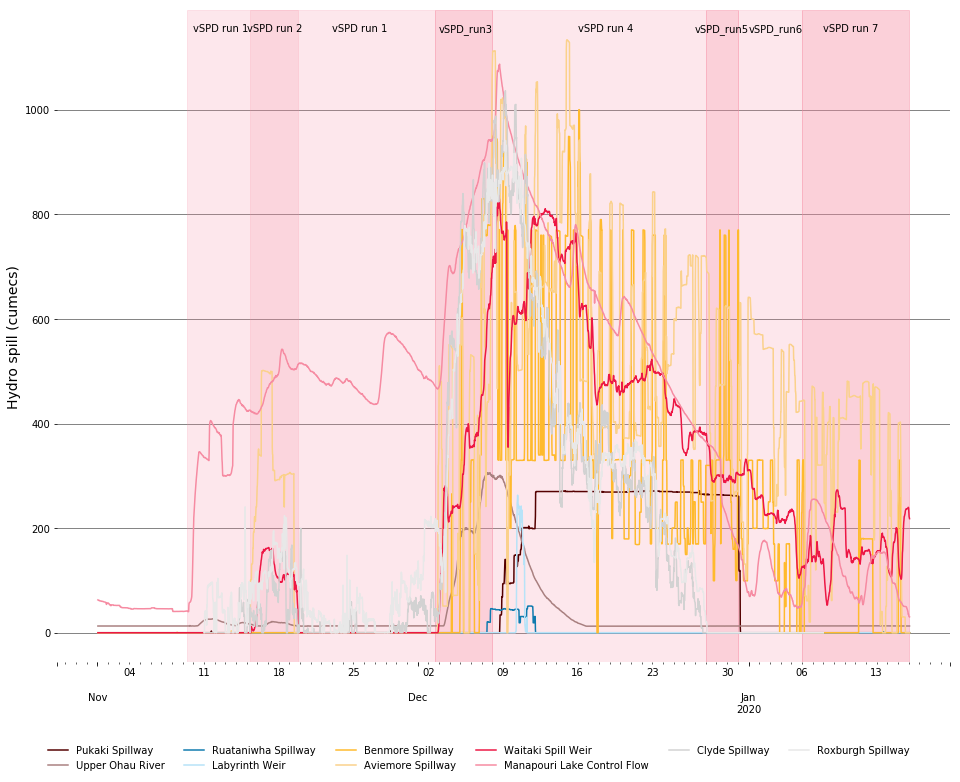

In [4]:
colours()
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
spill2.plot(ax=ax)
legend_format(ax, cols=6, ypos=-0.18)
plot_formatting(ax)
#UTS_period(ax)
plot_shading(ax, y_offset=1150)
ax.set_xlabel('')
ax.set_ylabel('Hydro spill (cumecs)', fontsize=14)

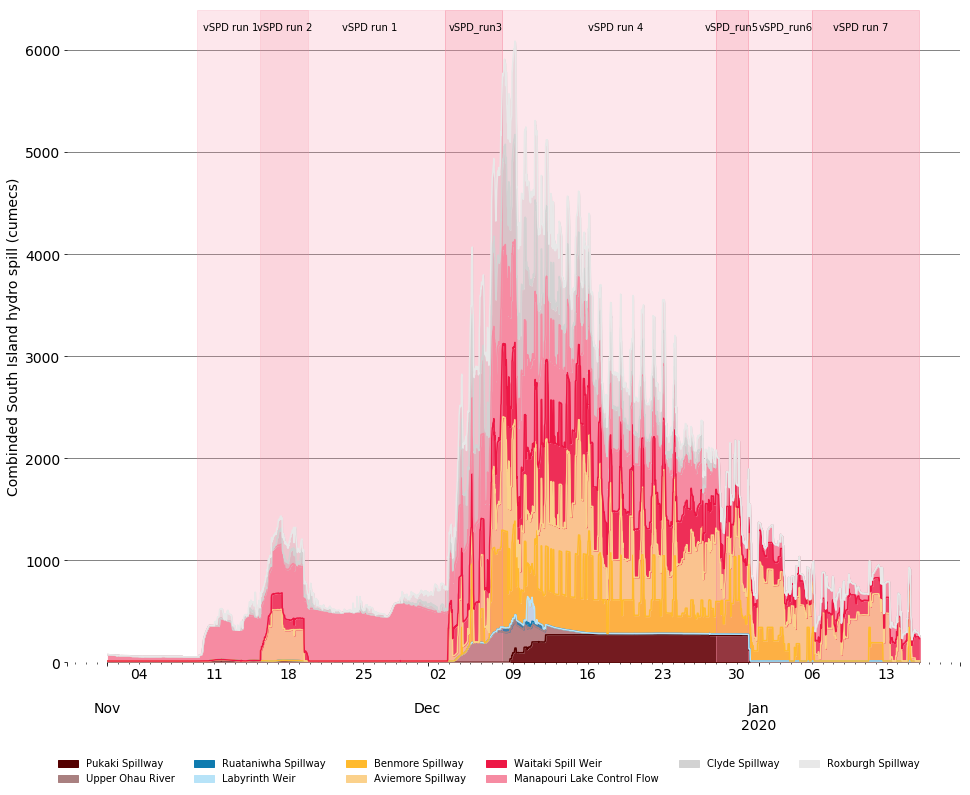

In [5]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)

spill2.sort_index(level=1).plot(kind='area', ax=ax, fontsize=14)
legend_format(ax, cols=5, fontsize=14, xpos=-0.04, ypos=-0.2)
ax.set_ylabel('Combinded South Island hydro spill (cumecs)', fontsize=14)
legend_format(ax, cols=6, ypos=-0.2)
plot_formatting(ax)
#UTS_period(ax)
plot_shading(ax, y_offset=6200)


#### Basecase vSPD runs

For each of these time periods we first performed a basecase vSPD run which outputted results that matched final pricing, i.e., what was settled in the wholesale spot market at the time.  

#### Low offer vSPD runs
We then altered SI hydro generation offer prices at the generators that were spilling.  We did this for several lower offer prices to investigate the effects, if particular we looked at changing offer prices to spilling generators with the following offers:

  - \$0/MWh
  - \$0.01/MWh (results illustrated below)
  - \$6.35/MWh (results illustrated below)
  - \$10/MWh (results illustrated below)
  - \$20/MWh (results illustrated below)
  - \$30/MWh (results illustrated below)

#### Notes on Transmission constraints

When lowering offer prices, and potentially increasing generation output we were careful to ensure that transmission constraints were included in the vSPD formulation.  This is required because a change in generation offer behaviour will result in increased LSI generation and the potential for transmission constraints out of the Lower South Island to bind.  These constraints were not necessary in the base case Final Pricing cases.  

The System Operator, in the pricing schedules and in final pricing, uses a tool called the Simultaneous    Feasibility Test (SFT).  This test is an AC power flow model of the current network configuration that automatically builds transmission constraints on-the-fly to ensure the transmission network can operate if a single element, like a single circuit or transformer, trips (called N-1).  As we do not have this tool we relied on both historically built constraints, as well as contracting System Operator engineers to check and manually model these transmission constraints.  A complicating factor during the flood event was the damage, and consequent loss of a section of transmission line on the Rangitata River that feeds Christchurch and the Upper South Island (USI).  This occurred in the evening of 7 December 2019.

Two LSI transmission constraints were required to be manually added to the vSPD runs to ensure the  transmission system operated within its means.  These were:

   - between Aviemore and Benmore on the Waitaki river, this constraint in particular is import to model following the damage and long term outage that has occurred on the Livingston - Islington transmission line[<sup>1</sup>](#fn1).
   - over-loading on the Roxburgh - Naseby transmission line following a trip on either of the Clyde - Roxburgh transmission circuits[<sup>2</sup>](#fn2). 

<span id="fn1"> [1] **AVI_BEN constraint (in vSPDsolve.gms)**

<sub> The AVI_BEN transmission constraints added to vSPDsolve.gms were:</sub>
    
<sub>i_tradePeriodBranchConstraintFactors(i_TradePeriod,'AVI_BEN1.1__AVI_BEN2.1__AVI_BEN2__AVI__LN','AVI_BEN1.1') = 1.216 ; i_tradePeriodBranchConstraintFactors(i_TradePeriod,'AVI_BEN1.1__AVI_BEN2.1__AVI_BEN2__AVI__LN','AVI_BEN2.1') = 0.921 ; i_tradePeriodBranchConstraintRHS(i_TradePeriod,'AVI_BEN1.1__AVI_BEN2.1__AVI_BEN2__AVI__LN','i_constraintLimit') = 250 ; i_tradePeriodBranchConstraintRHS(i_TradePeriod,'AVI_BEN1.1__AVI_BEN2.1__AVI_BEN2__AVI__LN','i_constraintSense') = -1 ;
    </sub>
    
<span id="fn2"> [2]**NSY_ROX constraint (in vSPDsolve.gms)**
    
<sub>This constraint is managed with a Special Protection Scheme (SPS) which, following a detection of an over-load on the Roxburgh - Naseby circuit, splits the Roxburgh 220kV bus.  Following this split, the effective impedance of the Roxburgh - Naseby circuit is increased which reduces the power flow and relieves the constraint.  One issue with this scheme during high LSI hydro generation is that it could inadvertently trigger by steady states flows if flows reach close to the steady states transmission limit on the Roxburgh - Naseby circuit.  To ensure that this does not occur the System Operator added manual constraint equations in the vSPD model to ensure that this transmission line did not inadvertently trip in steady state.  Although this sounds like a large change, it is not and this constraint should have always existed as part of the SPS scheme.  Possibly the trigger level for the operation of the scheme (the line flow on the Roxburgh - Naseby circuit) should have been increased to temporary 15 minute off-load limits which would allow slightly more transmission out of the LSI region.  The NSY_ROX transmission  constraints added to vSPDsolve.gms were:
    </sub>
   
<sub>i_tradePeriodBranchConstraintFactors(i_TradePeriod,'NSY_ROX.1__CYD_TWZ1.1__:S__CYD_TWZ1__ROX__LN','NSY_ROX.1') = -1 ; i_tradePeriodBranchConstraintFactors(i_TradePeriod,'NSY_ROX.1__CYD_TWZ1.1__:S__CYD_TWZ1__ROX__LN','CYD_TWZ1.1') = -0.084 ; i_tradePeriodBranchConstraintFactors(i_TradePeriod,'NSY_ROX.1__CYD_TWZ2.1__:S__CYD_TWZ2__ROX__LN','NSY_ROX.1') = -1 ; i_tradePeriodBranchConstraintFactors(i_TradePeriod,'NSY_ROX.1__CYD_TWZ2.1__:S__CYD_TWZ2__ROX__LN','CYD_TWZ2.1') = -0.084 ;
    </sub>

<sub>i_tradePeriodBranchConstraintRHS(i_TradePeriod,'NSY_ROX.1__CYD_TWZ1.1__:S__CYD_TWZ1__ROX__LN','i_constraintLimit') = 220 ; i_tradePeriodBranchConstraintRHS(i_TradePeriod,'NSY_ROX.1__CYD_TWZ1.1__:S__CYD_TWZ1__ROX__LN','i_constraintSense') = -1 ; i_tradePeriodBranchConstraintRHS(i_TradePeriod,'NSY_ROX.1__CYD_TWZ2.1__:S__CYD_TWZ2__ROX__LN','i_constraintLimit') = 220 ; i_tradePeriodBranchConstraintRHS(i_TradePeriod,'NSY_ROX.1__CYD_TWZ2.1__:S__CYD_TWZ2__ROX__LN','i_constraintSense') = -1 ;
    </sub>
    
</span>


In [6]:
# Load vSPD results using parquet files = this is FAST!
path = "vSPD_data/"

bc = vSPD_loader(path, basecase, csv=False)
bc2 = vSPD_loader(path, basecase2, csv=False)
bc3 = vSPD_loader(path, basecase3, csv=False)

# Load $0.01/MWh vSPD run
run1_001MWh = vSPD_loader(path, vSPDrun1_001MWh, csv=False)
run2_001MWh = vSPD_loader(path, vSPDrun2_001MWh, csv=False)
run3_001MWh = vSPD_loader(path, vSPDrun3_001MWh, csv=False)
run4_001MWh = vSPD_loader(path, vSPDrun4_001MWh, csv=False)
run5_001MWh = vSPD_loader(path, vSPDrun5_001MWh, csv=False)
run6_001MWh = vSPD_loader(path, vSPDrun6_001MWh, csv=False)
run7_001MWh = vSPD_loader(path, vSPDrun7_001MWh, csv=False)

# Load $6pt35/MWh vSPD run
run1_6pt35 = vSPD_loader(path, vSPDrun1_6pt35, csv=False)
run2_6pt35 = vSPD_loader(path, vSPDrun2_6pt35, csv=False)
run3_6pt35 = vSPD_loader(path, vSPDrun3_6pt35, csv=False)
run4_6pt35 = vSPD_loader(path, vSPDrun4_6pt35, csv=False)
run5_6pt35 = vSPD_loader(path, vSPDrun5_6pt35, csv=False)
run6_6pt35 = vSPD_loader(path, vSPDrun6_6pt35, csv=False)
run7_6pt35 = vSPD_loader(path, vSPDrun7_6pt35, csv=False)

# Load $10/MWh vSPD run
run1_10MWh = vSPD_loader(path, vSPDrun1_10MWh, csv=False)
run2_10MWh = vSPD_loader(path, vSPDrun2_10MWh, csv=False)
run3_10MWh = vSPD_loader(path, vSPDrun3_10MWh, csv=False)
run4_10MWh = vSPD_loader(path, vSPDrun4_10MWh, csv=False)
run5_10MWh = vSPD_loader(path, vSPDrun5_10MWh, csv=False)
run6_10MWh = vSPD_loader(path, vSPDrun6_10MWh, csv=False)
run7_10MWh = vSPD_loader(path, vSPDrun7_10MWh, csv=False)

# Load $13.7/MWh vSPD run
run1_13pt7MWh = vSPD_loader(path, vSPDrun1_13pt7MWh, csv=False)
run2_13pt7MWh = vSPD_loader(path, vSPDrun2_13pt7MWh, csv=False)
run3_13pt7MWh = vSPD_loader(path, vSPDrun3_13pt7MWh, csv=False)
run4_13pt7MWh = vSPD_loader(path, vSPDrun4_13pt7MWh, csv=False)
run5_13pt7MWh = vSPD_loader(path, vSPDrun5_13pt7MWh, csv=False)
run6_13pt7MWh = vSPD_loader(path, vSPDrun6_13pt7MWh, csv=False)
run7_13pt7MWh = vSPD_loader(path, vSPDrun7_13pt7MWh, csv=False)

# Load $20/MWh vSPD run
run1_20MWh = vSPD_loader(path, vSPDrun1_20MWh, csv=False)
run2_20MWh = vSPD_loader(path, vSPDrun2_20MWh, csv=False)
run3_20MWh = vSPD_loader(path, vSPDrun3_20MWh, csv=False)
run4_20MWh = vSPD_loader(path, vSPDrun4_20MWh, csv=False)
run5_20MWh = vSPD_loader(path, vSPDrun5_20MWh, csv=False)
run6_20MWh = vSPD_loader(path, vSPDrun6_20MWh, csv=False)
run7_20MWh = vSPD_loader(path, vSPDrun7_20MWh, csv=False)

# Load $30/MWh vSPD run
run1_30MWh = vSPD_loader(path, vSPDrun1_30MWh, csv=False)
run2_30MWh = vSPD_loader(path, vSPDrun2_30MWh, csv=False)
run3_30MWh = vSPD_loader(path, vSPDrun3_30MWh, csv=False)
run4_30MWh = vSPD_loader(path, vSPDrun4_30MWh, csv=False)
run5_30MWh = vSPD_loader(path, vSPDrun5_30MWh, csv=False)
run6_30MWh = vSPD_loader(path, vSPDrun6_30MWh, csv=False)
run7_30MWh = vSPD_loader(path, vSPDrun7_30MWh, csv=False)


Loading: vSPD_data/LSI_Flood_Basecase_BusResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_ReserveResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_SystemResults.parquet
Loading: vSPD_data/LSI_Flood_Basecase_BrConstraintResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_OfferResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_NodeResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_BranchResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_TraderResults.parquet
Loading: vSPD_data/LSI_Flood_Basecase_MNodeConstraintResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_SummaryResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_IslandResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_BidResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_ScarcityResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_2_BusResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_2_ReserveResults_TP.parquet
Loading: vSPD_data/LSI_Flood_Basecase_2_SystemRes

In [7]:
# Piece together the three base caser runs - do this separately (three runs as UTS analysis was on-going at the time).
BC={}
for k in files.keys():
    print(k)
    BC[k] = bc[k].append(bc2[k]).append(bc3[k])

bus_res
res_res
sys_res
brC_res
gen_res
nod_res
brh_res
trd_res
MNC_res
sum_res
isl_res
bid_res
scr_res


In [8]:
# Piece together the 7 time periods for each of the different simulations
ALL_RUNS_001MWh = piece_together_vSPD_runs(run1_001MWh, run2_001MWh, run3_001MWh, run4_001MWh,
                                          run5_001MWh, run6_001MWh, run7_001MWh, files)
ALL_RUNS_6pt35 = piece_together_vSPD_runs(run1_6pt35, run2_6pt35, run3_6pt35, run4_6pt35,
                                          run5_6pt35, run6_6pt35, run7_6pt35, files)
ALL_RUNS_10MWh = piece_together_vSPD_runs(run1_10MWh, run2_10MWh, run3_10MWh, run4_10MWh,
                                          run5_10MWh, run6_10MWh, run7_10MWh, files)
ALL_RUNS_13pt7 = piece_together_vSPD_runs(run1_13pt7MWh, run2_13pt7MWh, run3_13pt7MWh, run4_13pt7MWh,
                                          run5_13pt7MWh, run6_13pt7MWh, run7_13pt7MWh, files)
ALL_RUNS_20MWh = piece_together_vSPD_runs(run1_20MWh, run2_20MWh, run3_20MWh, run4_20MWh,
                                          run5_20MWh, run6_20MWh, run7_20MWh, files)
ALL_RUNS_30MWh = piece_together_vSPD_runs(run1_30MWh, run2_30MWh, run3_30MWh, run4_30MWh,
                                          run5_30MWh, run6_30MWh, run7_30MWh, files)


bus_res
res_res
sys_res
brC_res
gen_res
nod_res
brh_res
trd_res
MNC_res
sum_res
isl_res
bid_res
scr_res
bus_res
res_res
sys_res
brC_res
gen_res
nod_res
brh_res
trd_res
MNC_res
sum_res
isl_res
bid_res
scr_res
bus_res
res_res
sys_res
brC_res
gen_res
nod_res
brh_res
trd_res
MNC_res
sum_res
isl_res
bid_res
scr_res
bus_res
res_res
sys_res
brC_res
gen_res
nod_res
brh_res
trd_res
MNC_res
sum_res
isl_res
bid_res
scr_res
bus_res
res_res
sys_res
brC_res
gen_res
nod_res
brh_res
trd_res
MNC_res
sum_res
isl_res
bid_res
scr_res
bus_res
res_res
sys_res
brC_res
gen_res
nod_res
brh_res
trd_res
MNC_res
sum_res
isl_res
bid_res
scr_res


# Initial vSPD results
### Estimating additional hydro spill - ignoring physical hydrological constraints

The best method of comparing the difference between the different vSPD runs is to look at the change in dispatched generation.  We can do this easily by plotting the change in HVDC flow between the basecase vSPD run and the low offer LSI generation runs - although noting that this will be a bit lower than actual generation due to electrical network losses.  


In [10]:
# Return HVDC flow for different vSPD simulations
HVDC_BC = get_hvdc_flow(BC)["2019/12": "2019/12/27"]
HVDC_001MWh = get_hvdc_flow(ALL_RUNS_001MWh)["2019/12/3": "2019/12/27"]  
HVDC_6pt35 = get_hvdc_flow(ALL_RUNS_6pt35)["2019/12": "2019/12/27"]
HVDC_10MWh = get_hvdc_flow(ALL_RUNS_10MWh)["2019/12": "2019/12/27"]
HVDC_13pt7 = get_hvdc_flow(ALL_RUNS_13pt7)["2019/12": "2019/12/27"]
HVDC_20MWh = get_hvdc_flow(ALL_RUNS_20MWh)["2019/12": "2019/12/27"]
HVDC_30MWh = get_hvdc_flow(ALL_RUNS_30MWh)["2019/12": "2019/12/27"]


In [11]:

HVDC = pd.DataFrame({'Basecase (mean HVDC flow north: %iMW/%iGWh)' % (HVDC_BC.mean(), HVDC_BC.sum()/2000.0): HVDC_BC,
                     'LSI offers@$0.01/MWh (mean HVDC flow north: %iMW/%iGWh)' % (HVDC_001MWh.mean(), HVDC_001MWh.sum()/2000.0): HVDC_001MWh,
                     'LSI offers@$6.35/MWh (mean HVDC flow north: %iMW/%iGWh)' % (HVDC_6pt35.mean(), HVDC_6pt35.sum()/2000.0): HVDC_6pt35,
                     'LSI offers@$10/MWh (mean HVDC flow north: %iMW/%iGWh)' % (HVDC_10MWh.mean(), HVDC_10MWh.sum()/2000.0): HVDC_10MWh,
                     'LSI offers@$13pt7/MWh (mean HVDC flow north: %iMW/%iGWh)' % (HVDC_13pt7.mean(), HVDC_13pt7.sum()/2000.0): HVDC_13pt7,
                     'LSI offers@$20/MWh (mean HVDC flow north: %iMW/%iGWh)' % (HVDC_20MWh.mean(), HVDC_20MWh.sum()/2000.0): HVDC_20MWh,
                     'LSI offers@$30/MWh (mean HVDC flow north: %iMW/%iGWh)' % (HVDC_30MWh.mean(), HVDC_30MWh.sum()/2000.0): HVDC_30MWh})

Text(0.5, 1.0, 'HVDC flows for Basecase and vSPD runs (December 2019)')

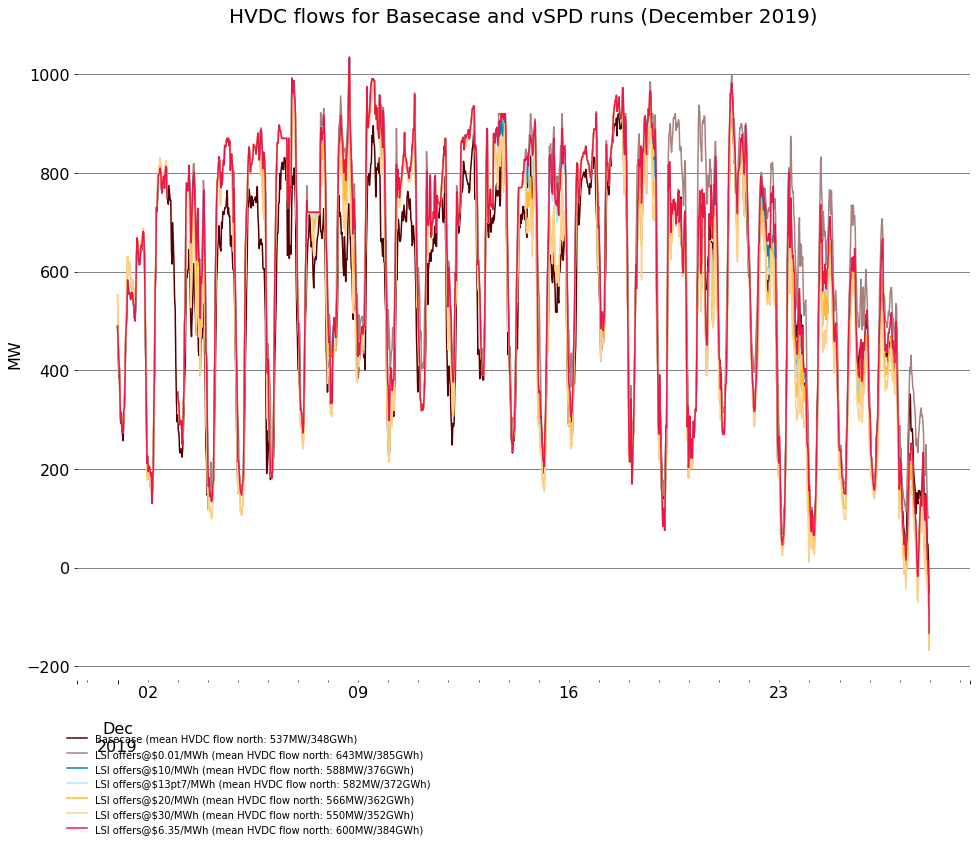

In [12]:
fig = plt.figure(1, figsize=[16, 12])
ax = fig.add_subplot(111)
HVDC.plot(ax=ax, fontsize=16)
plot_formatting(ax)
legend_format(ax, cols=1, ypos=-0.25)
ax.set_xlabel('')
ax.set_ylabel('MW', fontsize=16)
ax.set_title('HVDC flows for Basecase and vSPD runs (December 2019)', fontsize=20)


On first appearance the difference is relatively small.  There are various reasons for this but we think one of the main reasons is low offer prices in the North Island.  For example an offer at a North Island generation, say at \$0.01/MWh is likely to be dispatched ahead of the same offer in the South Island.  This is due to the nature of the wholesale spot market in New Zealand which takes into account electrical losses.  This means generation closer to load is favoured ahead of generation further away from load.

However the difference in HVDC flow add over time, as illustrated below.

Text(2020-01-01 12:00:00, 8.947741335000048, '12.0MW/8.9GWh')

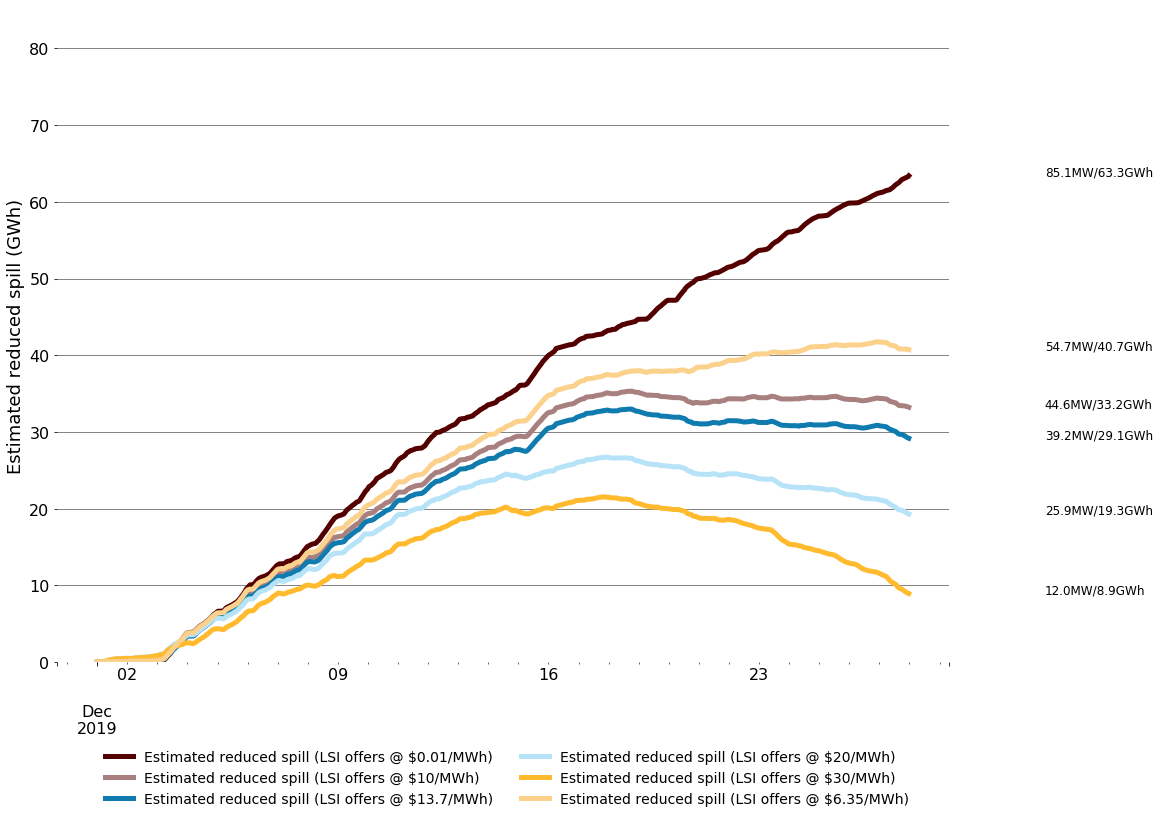

In [13]:

HVDC_diff_001MWh = (HVDC_001MWh-HVDC_BC).fillna(method='ffill')
HVDC_diff_6pt35 = (HVDC_6pt35-HVDC_BC).fillna(method='ffill')
HVDC_diff_10MWh = (HVDC_10MWh-HVDC_BC).fillna(method='ffill')
HVDC_diff_13pt7 = (HVDC_13pt7-HVDC_BC).fillna(method='ffill')
HVDC_diff_20MWh = (HVDC_20MWh-HVDC_BC).fillna(method='ffill')
HVDC_diff_30MWh = (HVDC_30MWh-HVDC_BC).fillna(method='ffill')

HVDC_diff_001MWh_cs = HVDC_diff_001MWh.cumsum()/2e3
HVDC_diff_6pt35_cs = HVDC_diff_6pt35.cumsum()/2e3
HVDC_diff_10MWh_cs = HVDC_diff_10MWh.cumsum()/2e3
HVDC_diff_13pt7_cs = HVDC_diff_13pt7.cumsum()/2e3
HVDC_diff_20MWh_cs = HVDC_diff_20MWh.cumsum()/2e3
HVDC_diff_30MWh_cs = HVDC_diff_30MWh.cumsum()/2e3

df = pd.DataFrame({'Estimated reduced spill (LSI offers @ $0.01/MWh)': HVDC_diff_001MWh_cs,
                   'Estimated reduced spill (LSI offers @ $6.35/MWh)': HVDC_diff_6pt35_cs,
                   'Estimated reduced spill (LSI offers @ $10/MWh)': HVDC_diff_10MWh_cs,
                   'Estimated reduced spill (LSI offers @ $13.7/MWh)': HVDC_diff_13pt7_cs,
                   'Estimated reduced spill (LSI offers @ $20/MWh)': HVDC_diff_20MWh_cs,
                   'Estimated reduced spill (LSI offers @ $30/MWh)': HVDC_diff_30MWh_cs})

fig = plt.figure(1, figsize=[16, 12])
ax = fig.add_subplot(111)
df["2019/12"].plot(lw=5, ax=ax, fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Estimated reduced spill (GWh)', fontsize=18)
ax.set_ylim([0, 85])
plot_formatting(ax)
legend_format(ax, fontsize=14, xpos=0.04, ypos=-.24, cols=2)
ax.text(datetime(2020,1,1,12), HVDC_diff_001MWh_cs[-1], str(int(10*HVDC_diff_001MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_001MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_6pt35_cs[-1], str(int(10*HVDC_diff_6pt35_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_6pt35_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_10MWh_cs[-1], str(int(10*HVDC_diff_10MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_10MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_13pt7_cs[-1], str(int(10*HVDC_diff_13pt7_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_13pt7_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_20MWh_cs[-1], str(int(10*HVDC_diff_20MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_20MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_30MWh_cs[-1], str(int(10*HVDC_diff_30MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_30MWh_cs[-1])/10) + 'GWh', fontsize=12)



In [14]:
# calculate average additional spill for December 2019 in ave. MW. 
(1000*df["2019/12/3": "2019/12/27"].tail(1).T["2019/12/27 23:30"]/(24*31)).sort_values()


Estimated reduced spill (LSI offers @ $30/MWh)      12.026534
Estimated reduced spill (LSI offers @ $20/MWh)      25.950505
Estimated reduced spill (LSI offers @ $13.7/MWh)    39.230216
Estimated reduced spill (LSI offers @ $10/MWh)      44.656463
Estimated reduced spill (LSI offers @ $6.35/MWh)    54.741652
Estimated reduced spill (LSI offers @ $0.01/MWh)    85.191238
Name: 2019-12-27 23:30:00, dtype: float64

In [15]:
# return difference in total system costs
sc_001 = calc_diff_sys_cost(BC, ALL_RUNS_001MWh)/1e6
sc_635 = calc_diff_sys_cost(BC, ALL_RUNS_6pt35)/1e6
sc_10 = calc_diff_sys_cost(BC, ALL_RUNS_10MWh)/1e6
sc_137 = calc_diff_sys_cost(BC, ALL_RUNS_13pt7)/1e6
sc_20 = calc_diff_sys_cost(BC, ALL_RUNS_20MWh)/1e6
sc_30 = calc_diff_sys_cost(BC, ALL_RUNS_30MWh)/1e6

sys_cost = pd.DataFrame({'$0.01/MWh': sc_001,
                         '$6.35/MWh': sc_635,
                        '$10/MWh': sc_10,
                        '$13.7/MWh': sc_137,
                        '$20/MWh': sc_20,
                        '$30/MWh': sc_30})


Text(0, 0.5, '$m')

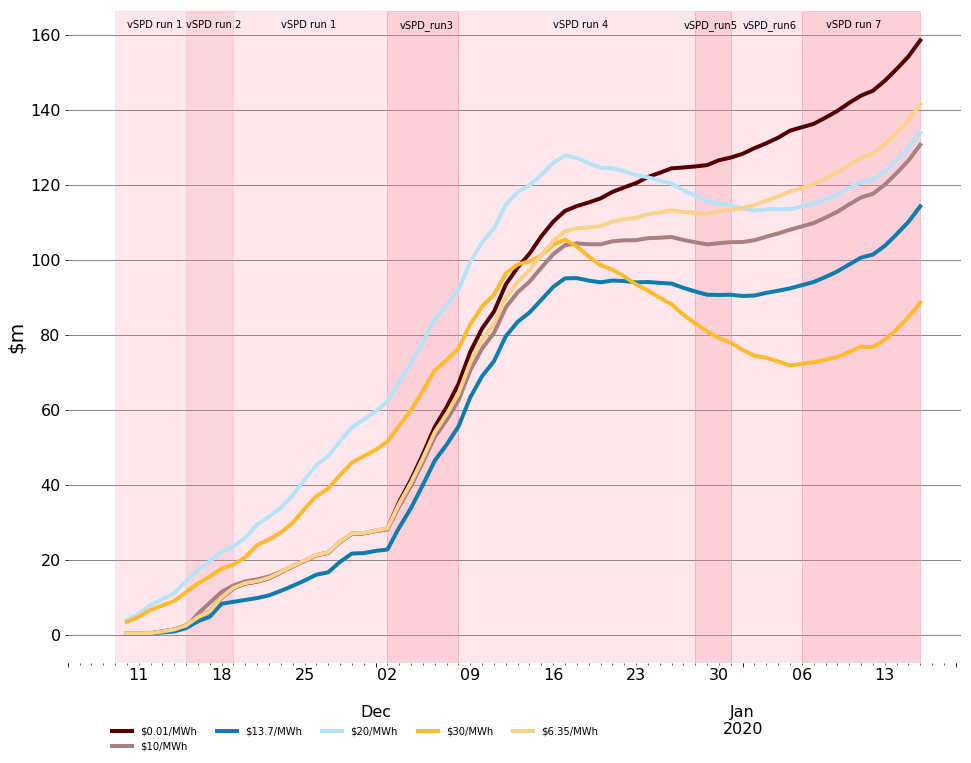

In [16]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
sys_cost.cumsum().interpolate().plot(ax=ax, lw=4, fontsize=16)
plot_shading(ax, y_offset=162)
plot_formatting(ax)
legend_format(ax, xpos=0.04, cols=5)
ax.set_xlabel('')
ax.set_ylabel('$m', fontsize=20)



Text(2019-12-28 12:00:00, 33.861729389999994, '$33.86m')

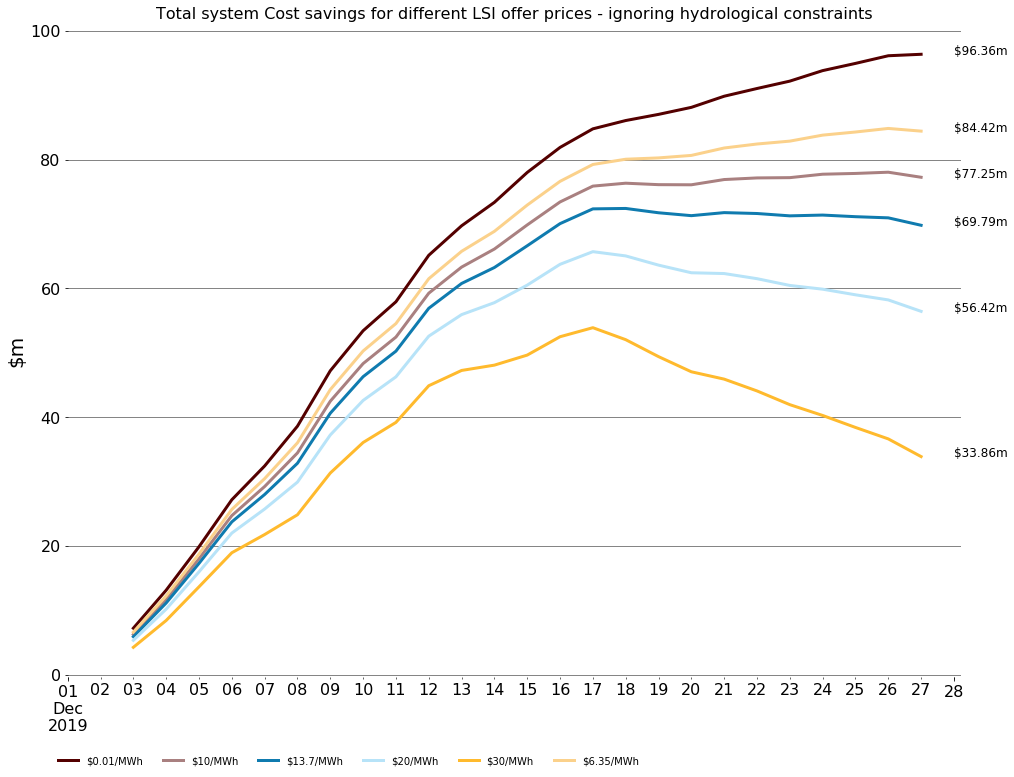

In [17]:
# UTS period (this is the period agreed by the EA board)
UTS_start = "2019/12/3"
UTS_end = "2019/12/27"
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
sys_cost_cs = sys_cost[UTS_start: UTS_end].cumsum()
sys_cost_cs.plot(ax=ax, lw=3, fontsize=16)
plot_formatting(ax)
legend_format(ax, cols=6)
ax.set_ylabel('$m', fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.set_title('Total system Cost savings for different LSI offer prices - ignoring hydrological constraints', fontsize=16)

ax.text(datetime(2019,12,28,12), sys_cost_cs.tail(1)["$0.01/MWh"].values[0], '$' + str(int(100*sys_cost_cs.tail(1)["$0.01/MWh"].values[0])/100) + 'm', fontsize=12)
ax.text(datetime(2019,12,28,12), sys_cost_cs.tail(1)["$6.35/MWh"].values[0], '$' + str(int(100*sys_cost_cs.tail(1)["$6.35/MWh"].values[0])/100) + 'm', fontsize=12)
ax.text(datetime(2019,12,28,12), sys_cost_cs.tail(1)["$10/MWh"].values[0], '$' + str(int(100*sys_cost_cs.tail(1)["$10/MWh"].values[0])/100) + 'm', fontsize=12)
ax.text(datetime(2019,12,28,12), sys_cost_cs.tail(1)["$13.7/MWh"].values[0], '$' + str(int(100*sys_cost_cs.tail(1)["$13.7/MWh"].values[0])/100) + 'm', fontsize=12)
ax.text(datetime(2019,12,28,12), sys_cost_cs.tail(1)["$20/MWh"].values[0], '$' + str(int(100*sys_cost_cs.tail(1)["$20/MWh"].values[0])/100) + 'm', fontsize=12)
ax.text(datetime(2019,12,28,12), sys_cost_cs.tail(1)["$30/MWh"].values[0], '$' + str(int(100*sys_cost_cs.tail(1)["$30/MWh"].values[0])/100) + 'm', fontsize=12)
#savefig("/media/P/Dave/temp/UTS_2019_updated_SYS_cost_ignoring_hydro_constraints.png", bbox_inches='tight')

In [18]:
sys_cost_cs.tail(1)["$13.7/MWh"].values[0]

69.7973902

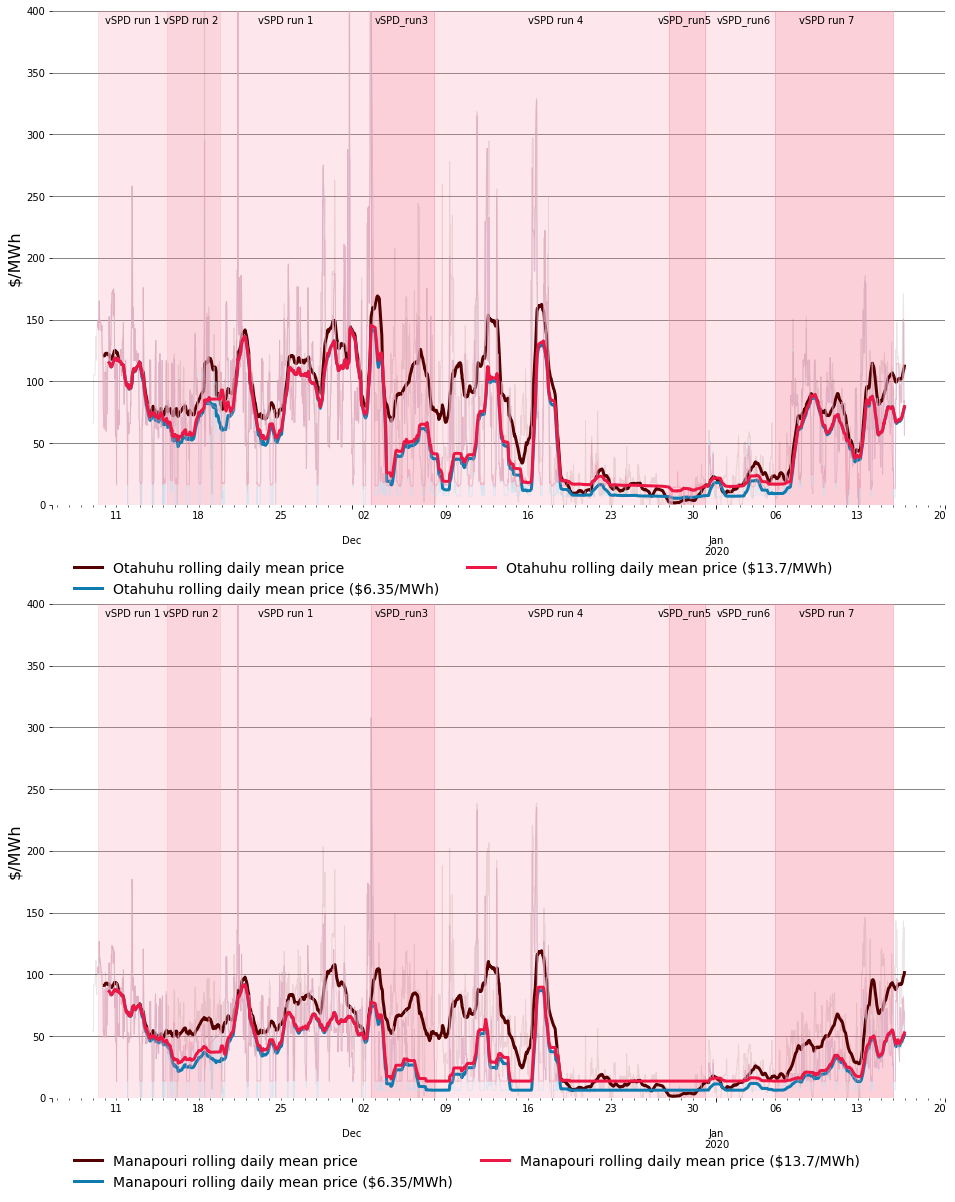

In [19]:
fig = plt.figure(1, figsize=[16,20])
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
#MAN
BC['nod_res']['Price ($/MWh)'].unstack()['MAN2201 MAN0'].plot(ax=ax2, lw=1, alpha=0.1, fontsize=10, color=c_p['br1'], label='')
BC['nod_res']['Price ($/MWh)'].unstack()['MAN2201 MAN0'].rolling(48).mean().plot(ax=ax2, lw=3, fontsize=10, label='Manapouri rolling daily mean price')
ALL_RUNS_6pt35['nod_res']['Price ($/MWh)'].unstack()['MAN2201 MAN0'].plot(ax=ax2, lw=1, alpha=0.5, fontsize=10, color=c_p['bl2'], label='')
ALL_RUNS_6pt35['nod_res']['Price ($/MWh)'].unstack()['MAN2201 MAN0'].rolling(48).mean().plot(ax=ax2, lw=3, fontsize=10, color=c_p['bl1'], label='Manapouri rolling daily mean price ($6.35/MWh)' )
ALL_RUNS_13pt7['nod_res']['Price ($/MWh)'].unstack()['MAN2201 MAN0'].plot(ax=ax2, lw=1, alpha=0.5, fontsize=10, color=c_p['rd2'], label='')
ALL_RUNS_13pt7['nod_res']['Price ($/MWh)'].unstack()['MAN2201 MAN0'].rolling(48).mean().plot(ax=ax2, lw=3, fontsize=10, color=c_p['rd1'], label='Manapouri rolling daily mean price ($13.7/MWh)' )
#OTA
BC['nod_res']['Price ($/MWh)'].unstack()['OTA2201'].plot(ax=ax, lw=1, alpha=0.1, fontsize=10, color=c_p['br1'], label='')
BC['nod_res']['Price ($/MWh)'].unstack()['OTA2201'].rolling(48).mean().plot(ax=ax, lw=3, fontsize=10, label='Otahuhu rolling daily mean price')
ALL_RUNS_6pt35['nod_res']['Price ($/MWh)'].unstack()['OTA2201'].plot(ax=ax, lw=1, alpha=0.5, fontsize=10, color=c_p['bl2'], label='')
ALL_RUNS_6pt35['nod_res']['Price ($/MWh)'].unstack()['OTA2201'].rolling(48).mean().plot(ax=ax, lw=3, fontsize=10, color=c_p['bl1'], label='Otahuhu rolling daily mean price ($6.35/MWh)' )
ALL_RUNS_13pt7['nod_res']['Price ($/MWh)'].unstack()['OTA2201'].plot(ax=ax, lw=1, alpha=0.5, fontsize=10, color=c_p['rd2'], label='')
ALL_RUNS_13pt7['nod_res']['Price ($/MWh)'].unstack()['OTA2201'].rolling(48).mean().plot(ax=ax, lw=3, fontsize=10, color=c_p['rd1'], label='Otahuhu rolling daily mean price ($13.7/MWh)' )

ax.set_ylabel('$/MWh', fontsize=16)
ax.set_xlabel('')
ax2.set_xlabel('')
ax2.set_ylabel('$/MWh', fontsize=16)

ax.set_ylim([0, 400])
ax2.set_ylim([0, 400])
plot_formatting(ax)
plot_formatting(ax2)
plot_shading(ax, y_offset=390)
plot_shading(ax2, y_offset=390)
legend_format(ax, cols=2, ypos=-0.21, xpos=0.01, fontsize=14)
legend_format(ax2, cols=2, ypos=-0.21, xpos=0.01, fontsize=14)



In [20]:

HVDC_BC = get_hvdc_flow(BC)
HVDC_001MWh = get_hvdc_flow(ALL_RUNS_001MWh)
HVDC_6pt35 = get_hvdc_flow(ALL_RUNS_6pt35)
HVDC_10MWh = get_hvdc_flow(ALL_RUNS_10MWh)
HVDC_13pt7 = get_hvdc_flow(ALL_RUNS_13pt7)
HVDC_20MWh = get_hvdc_flow(ALL_RUNS_20MWh)
HVDC_30MWh = get_hvdc_flow(ALL_RUNS_30MWh)

### Estimating additional hydro spill - including physical hydrological constraints

One problem with the vSPD simulations above is the lack of modelling of physical constraints outside of the vSPD market model.  In this instance these constraints are environmental and hydrological in nature and are not part of the vSPD or SPD formulation.   For example, a lot of the spill at Manapouri is due to the environmental resource consent conditions as detailed in our main report.  A second issue we discovered after discussions with Meridian is the 'no-go' zone on the Benmore spillway.  

The details of the specific steps we undertook to estimate the excess spill, in particular related to the Benmore spillway issue, are as follows:

    a) All South Island generators except Benmore were modelled to generate the same as they did during the flood event – we use reconciliation (RM) data for this.
    
    b) Using vSPD we determined total South Island generation dispatched had all offers for spilling hydro stations been set to $0.01/MWh. This ensures all market constraints, including additional HVDC flow are satisfied, but ignores any spillway constraints at Benmore.
    
    c) The actual generation (RM data excluding Benmore) was subtracted from the total dispatch that the $0.01/MWh offer vSPD simulation predicts. This gave us a total potential Benmore generation series which is truncated at Benmore’s generation capacity. This is the new potential Benmore generation ignoring the spillway constraint.
    
    d) The Benmore RM data (what was actually generated) was then subtracted from this new potential Benmore generation to get the additional potential Benmore generation.
    
    e) This was then converted to cumecs and subtracted from the spill data which is also in cumecs. 
    
    f) If this resulted in spill within the no-go zone then the generation at Benmore in the trading period was discarded. 
    
    g) For those trading periods that result in an increase in generation, this generation was converted to MW, summed, and converted to GWh.  

The calculations for this analysis are below.  We first take a look at the Benmore spill and Benmore generation hydro flows.  Given the spillway constraints, we determine trading periods where, ignoring all other market constraints, we think Benmore could have physically generated more, for the same generator station through flow, satisfying the spillway constraints.   



In [21]:
# Get RM generation data during December for LSI generators

RMG_LSI = pd.read_parquet("data/201912_RMG_LSI.parquet")
RMG_BEN = RMG_LSI["BEN2202"]
RMG_MERI = RMG_LSI.loc[:, ['OHA2201', 'OHB2201', 'OHC2201', 'BEN2202', 'AVI2201', 'WTK0111', 'MAN2201']]
RMG_MERI_WTK = RMG_MERI.loc[:, ['OHA2201', 'OHB2201', 'OHC2201', 'BEN2202', 'AVI2201', 'WTK0111']]

# Benmore spill data
BEN_SPILL = MERI_spill['Benmore Spillway']["2019/12"]
BEN_SPILL.index = BEN_SPILL.index.map(lambda x: x+timedelta(seconds=15*60))
MAX_BEN_GEN_FLOW = 660
BEN_g_CUMECS = RMG_BEN*(MAX_BEN_GEN_FLOW/RMG_BEN.max())
CUMECS_to_MW = RMG_BEN.max()/MAX_BEN_GEN_FLOW
CUMECS_to_MW = 1/1.223  # https://www.emi.ea.govt.nz/Environment/Datasets/HydrologicalModellingDataset/1_InfrastructureAndHydroConstraintAttributes/20180726_InfrastructureAndHydroConstraintAttributes.csv

BEN_90MW_unit_outage = 1/CUMECS_to_MW*90

BEN_CUMECS = pd.DataFrame({'Spillway': BEN_SPILL,
                           'Generation': BEN_g_CUMECS, 
                           'Total': BEN_SPILL + BEN_g_CUMECS})


BEN_CUMECS['Max Generation'] = MAX_BEN_GEN_FLOW

# Take into account three 1 unit BEN POCP outages 
BEN_CUMECS['Max Generation'] ["2019/12/4T10:15": "2019/12/4T13:15"] = BEN_CUMECS['Max Generation'] ["2019/12/4T10:15": "2019/12/4T13:15"] - BEN_90MW_unit_outage
BEN_CUMECS['Max Generation'] ["2019/12/5T10:15": "2019/12/5T13:15"] = BEN_CUMECS['Max Generation'] ["2019/12/5T10:15": "2019/12/5T13:15"] - BEN_90MW_unit_outage
BEN_CUMECS['Max Generation'] ["2019/12/16T06:45": "2019/12/19T18:15"] = BEN_CUMECS['Max Generation'] ["2019/12/16T06:45": "2019/12/19T18:15"] - BEN_90MW_unit_outage

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5, 0, '')

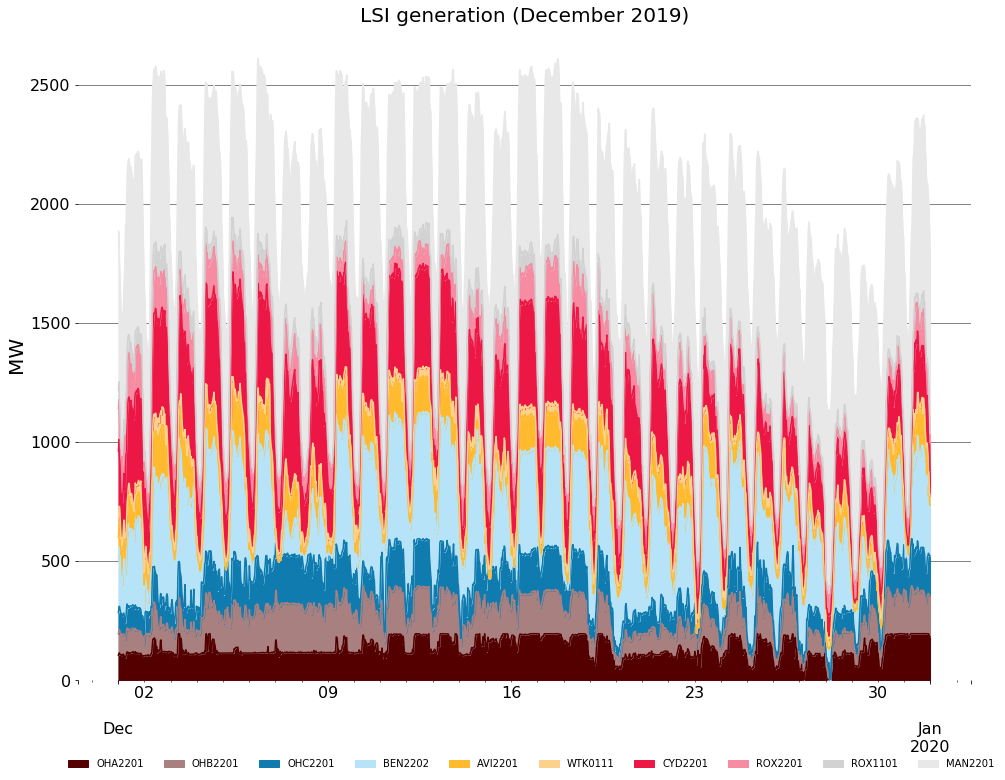

In [22]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
RMG_LSI.plot(kind='area', ax=ax, fontsize=16)
plot_formatting(ax)
legend_format(ax, cols=10)
ax.set_title('LSI generation (December 2019)', fontsize=20)
ax.set_ylabel('MW', fontsize=20)
ax.set_xlabel('')

Text(0.5, 1.0, 'Benmore Hydraulics')

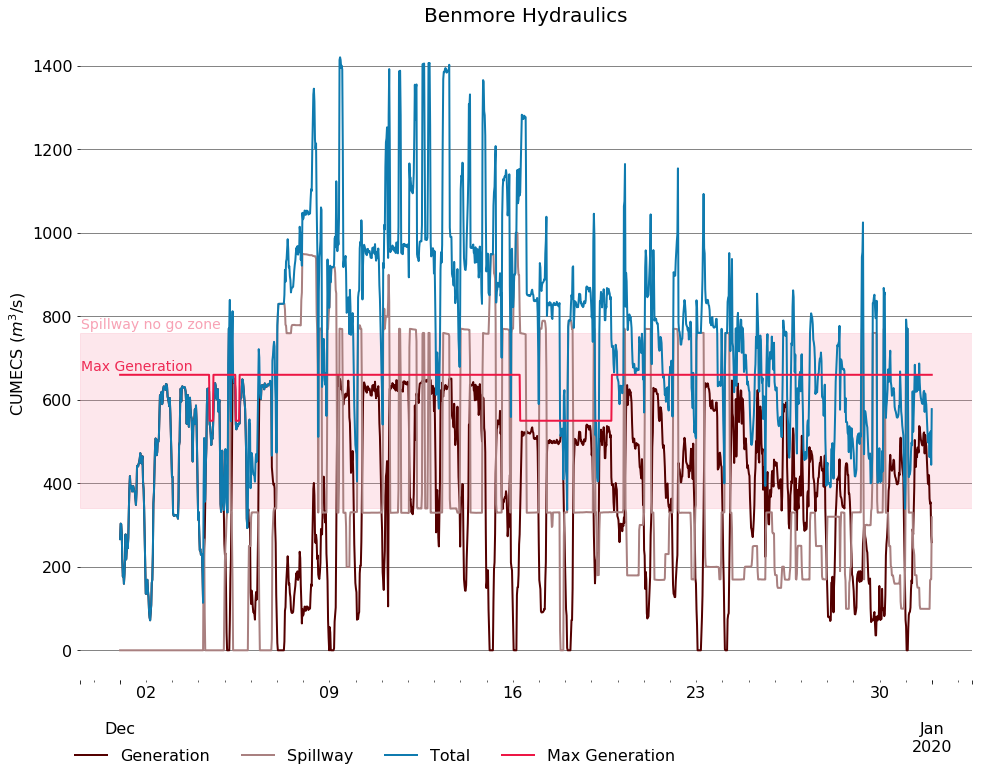

In [23]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
BEN_CUMECS['Generation'].plot(ax=ax, fontsize=16, lw=2, label='Generation')
BEN_CUMECS['Spillway'].plot(ax=ax, fontsize=16, lw=2, label='Spillway')
BEN_CUMECS['Total'].plot(ax=ax, fontsize=16, lw=2, label='Total')
BEN_CUMECS["Max Generation"].plot(ax=ax, fontsize=16, lw=2, color=c_p['rd1'])

ax.axhspan(340, 760, color = c_p['rd2'], alpha=0.2)

ax.set_ylabel('CUMECS ($m^3$/s)', fontsize=16)
ax.set_xlabel('', fontsize=16)
legend_format(ax, fontsize=16, cols=5)
plot_formatting(ax)
ax.text(datetime(2019,11,29, 12), 770, 'Spillway no go zone', color=c_p['rd1'],
        fontsize=14, alpha=0.4)
ax.text(datetime(2019,11,29, 12), 670, 'Max Generation', color=c_p['rd1'],
        fontsize=14, alpha=0.9)
ax.set_title('Benmore Hydraulics', fontsize=20)

### Need sort logic to determine periods of interest...

Here, we assume that the total spill that occurred is what is allowed.  This total must be made up from generation flow and spill flow that satisfy Benmores spillway constraint, i.e., generation flow<660cumecs + spill flow<340 or spill flow>760

Split into several constraints: 

  - periods when spilling
  - periods when total spill =  <660+340 (1000) = most periods...
  - total when total spill-760 <660 = all periods...

Then during these periods we calculate what could have been generated and the resulting spill that obeys the physical constraints of the Benmore spillway...

I.e.,

  - New Benmore generation = old_generation + spillway (under 660 cumecs).
  - New spill = old total - new generation
  
We discard trading periods that don't match this, although we note that lake Benmore storage could have allowed some flexibility and that in one may argue that this flexibility in lake level control could have allowed less spill to occur.  In this sense, we think this is a favourable assumption for Meridian.  

In [24]:
# BEN booleans
b1 = BEN_CUMECS.Spillway>0
b2 = BEN_CUMECS.Total<1000
b3 = BEN_CUMECS.Total-760 < BEN_CUMECS["Max Generation"]

boolean = (b1&b2&b3)

In [25]:
100*b1.sum()/b1.count()  # spilling 83.8% of the time during December

83.66935483870968

In [26]:
100*b2.sum()/b1.count()  # total Benmore through flow less than 1000cumecs 89.7% of the time during December

89.18010752688173

In [27]:
100*boolean.sum()/boolean.count()  # % of time when all conditions met

72.84946236559139

In [28]:
BEN_CUMECS_periods = BEN_CUMECS[boolean]


In [29]:
BEN_CUMECS_periods['New Generation']=(BEN_CUMECS_periods.Generation+BEN_CUMECS_periods.Spillway).clip_upper(BEN_CUMECS["Max Generation"])
BEN_CUMECS_periods['New Spill']=BEN_CUMECS_periods['Total'] - BEN_CUMECS_periods['New Generation']


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'CUMECS ($m^3$/s)')

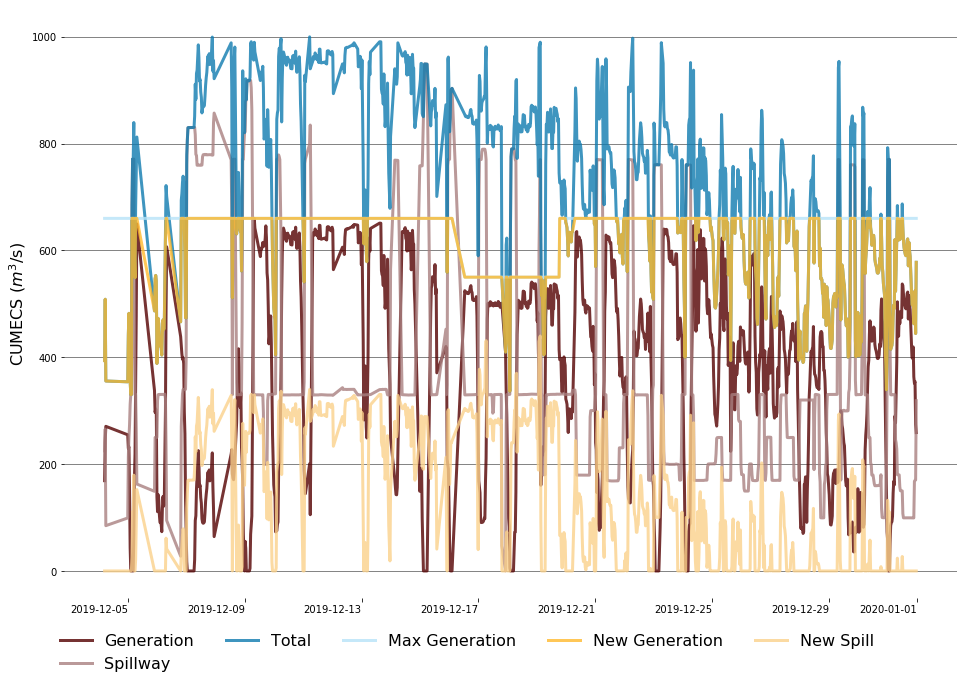

In [30]:

fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
BEN_CUMECS_periods.plot(ax=ax, lw=3, alpha=0.8)
legend_format(ax, fontsize=16, cols=5)
plot_formatting(ax)
ax.set_xlabel('')

ax.set_ylabel('CUMECS ($m^3$/s)', fontsize=16)

In [31]:
# add a few more columns
BEN_CUMECS_periods['Additional generation'] = (BEN_CUMECS_periods['New Generation'] - BEN_CUMECS_periods['Generation'])
BEN_CUMECS_periods = BEN_CUMECS_periods.loc[BEN_CUMECS_periods['Additional generation']>100,:]
BEN_CUMECS_periods = BEN_CUMECS_periods.reindex(BEN_CUMECS.index)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
potential_BEN_generation = pd.DataFrame({'Actual Benmore Generation': BEN_CUMECS['Generation'],
                                        'Potential Benmore Generation (ignoring market constraints)': BEN_CUMECS_periods['New Generation'] })

Text(0.5, 0, '')

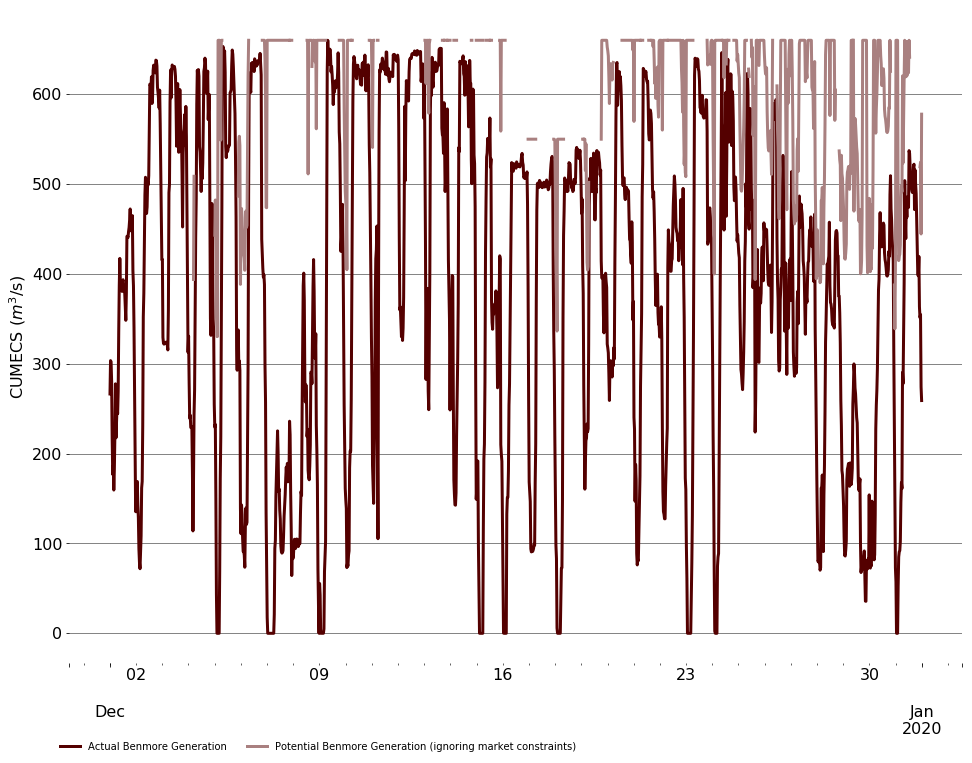

In [33]:

fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
potential_BEN_generation.plot(ax=ax, lw=3, fontsize=16)
plot_formatting(ax)
legend_format(ax)
ax.set_ylabel('CUMECS ($m^3$/s)', fontsize=16)
ax.set_xlabel('')

Text(0, 0.5, 'Cumecs (m$^3$)')

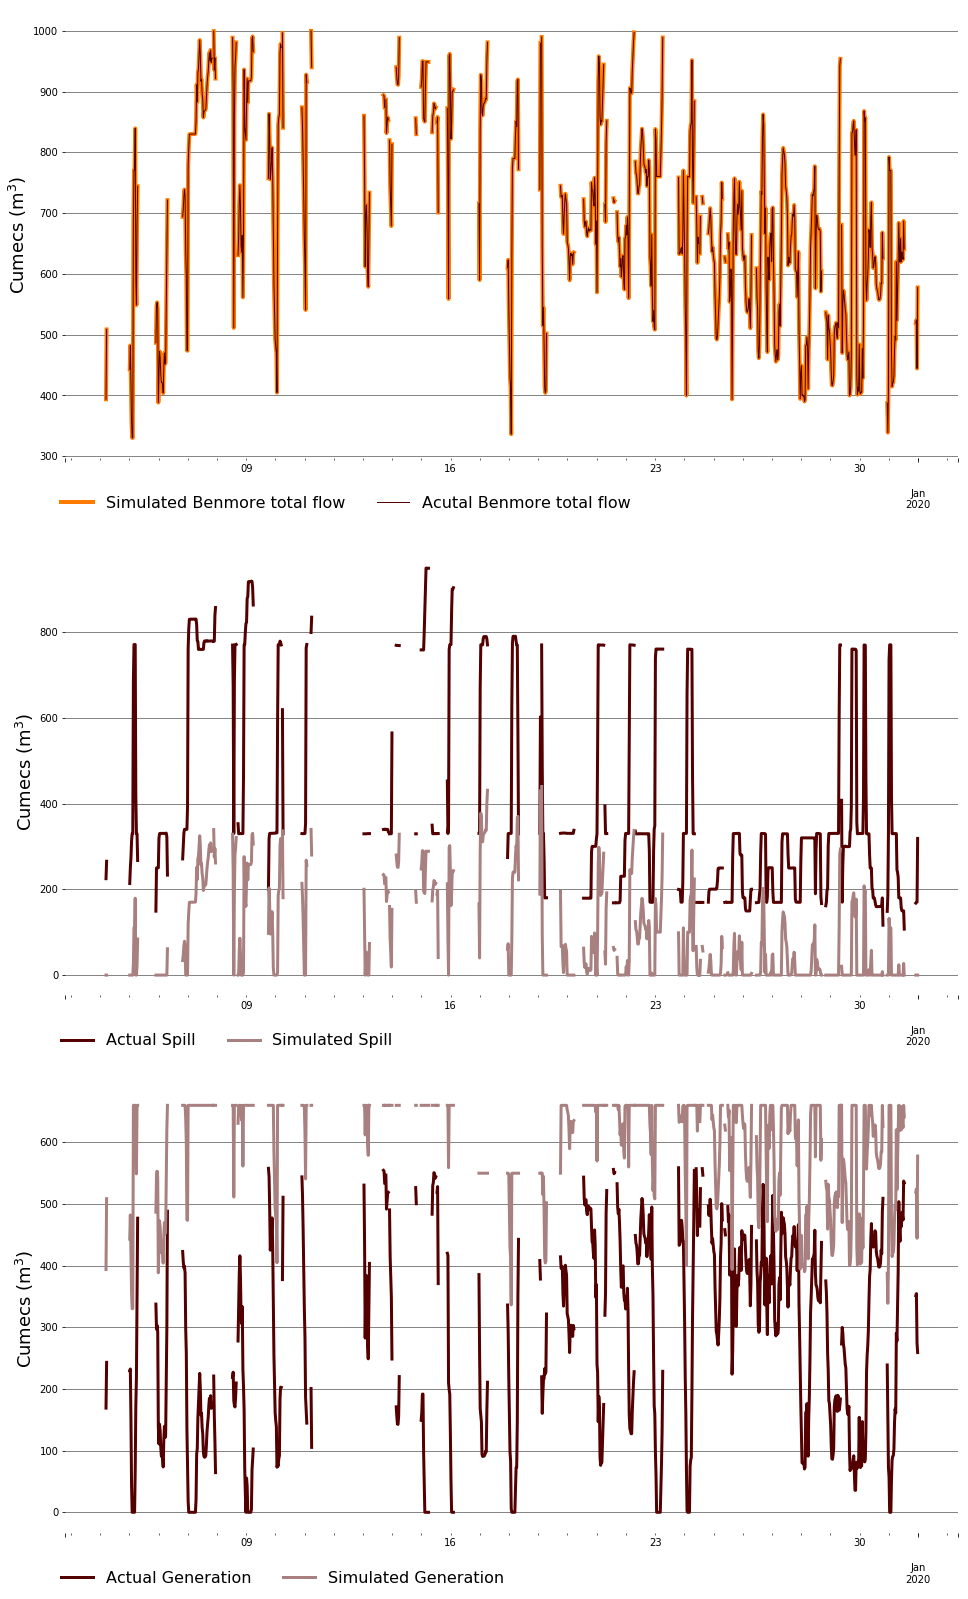

In [34]:

# Logic check - total Benmore flow and before should be equal
fig = plt.figure(1, figsize=[16,28])
ax = fig.add_subplot(311)
new_through_flow_check = BEN_CUMECS_periods['New Spill']+ BEN_CUMECS_periods['New Generation']
old_through_flow_check = BEN_CUMECS_periods['Generation'] + BEN_CUMECS_periods['Spillway']
df1 = pd.DataFrame({'New Benmore total through flow': new_through_flow_check,
                  'Old Benmore total through flow': old_through_flow_check})
df1['New Benmore total through flow'].plot(ax=ax, color=c_s['or1'], lw=4, label='Simulated Benmore total flow')
df1['Old Benmore total through flow'].plot(ax=ax, color=c_p['br1'], lw=1, label='Acutal Benmore total flow')
legend_format(ax, fontsize=16)
plot_formatting(ax)
ax.set_xlabel('')
ax.set_ylabel('Cumecs (m$^3$)', fontsize=18)

ax2 = fig.add_subplot(312)
df2 = pd.DataFrame({'Actual Spill': BEN_CUMECS_periods['Spillway'], 
                   'Simulated Spill': BEN_CUMECS_periods['New Spill']})
df2.plot(ax=ax2, lw=3)

legend_format(ax2, fontsize=16)
plot_formatting(ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Cumecs (m$^3$)', fontsize=18)

ax3 = fig.add_subplot(313)
df3 = pd.DataFrame({'Actual Generation': BEN_CUMECS_periods['Generation'], 
                   'Simulated Generation': BEN_CUMECS_periods['New Generation']})
df3.plot(ax=ax3, lw=3)
legend_format(ax3, fontsize=16)
plot_formatting(ax3)
ax3.set_xlabel('')
ax3.set_ylabel('Cumecs (m$^3$)', fontsize=18)

Text(0.5, 0, '')

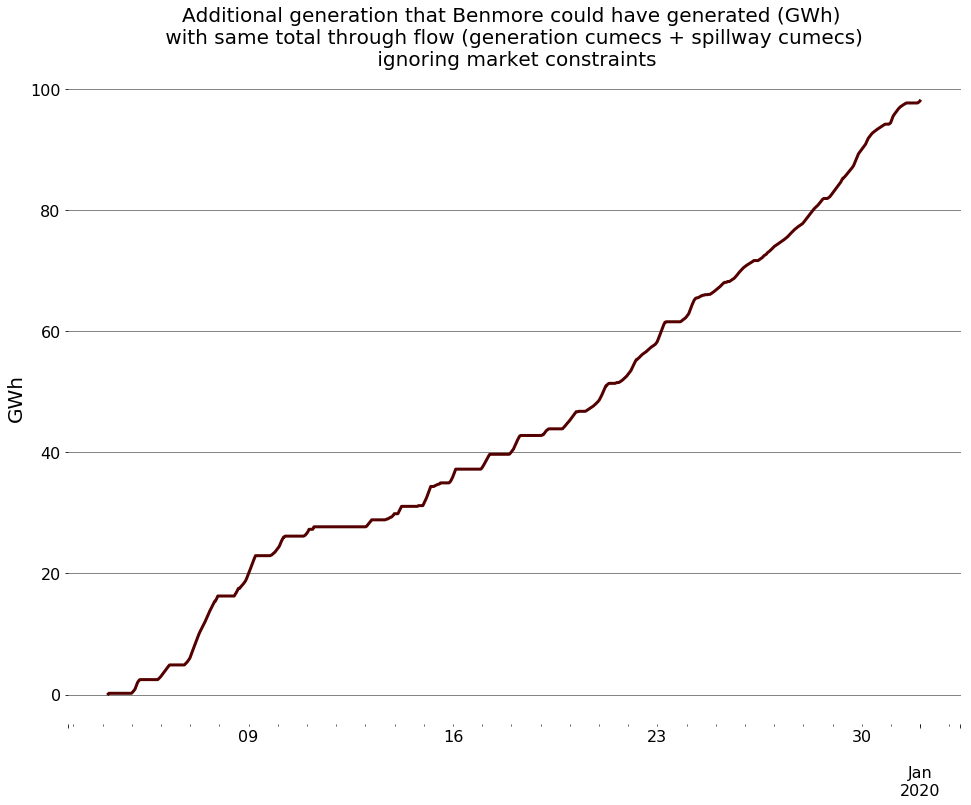

In [35]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)
ben_additional = (BEN_CUMECS_periods['Additional generation'].cumsum().fillna(method='ffill'))
ben_add_GWH = ((ben_additional*CUMECS_to_MW)/2000)  #Cumecs to MW to GWh
ben_add_GWH.plot(ax=ax, lw=3, fontsize=16)
ax.set_ylabel('GWh', fontsize=20)
ax.set_title('Additional generation that Benmore could have generated (GWh) \n with same total through flow (generation cumecs + spillway cumecs) \n ignoring market constraints', fontsize=20)
plot_formatting(ax)
ax.set_xlabel('')

We get a pretty consistent total average lost generation MW of about: 

In [36]:
str(int(1000*ben_add_GWH.iloc[-1]/(31*24))) + 'MW'


'131MW'

However, this ignores actual constraints in the Electricity Market.  

In other words, although this may be correct in a physical sense, Benmore would not have been able to achieve this generation output due to other market related constraints like low NI generation offers during evening periods, low demand periods, and/or HVDC/transmission constraints.

The next step we look at the LSI offer changes to \\$0.01/MWh vSPD results.  In these simulations we adjusted all of the LSI generator offers to \\$0.01/MWh and then re-ran the market model.  As Benmore and Pukaki generators are electrically closer to demand, they are favoured over other LSI generation.  

We used \\$0.01/MWh because our research question was "how much extra South Island generation could be generated and exported?" Using a zero price would have meant that North Island geothermal and wind would have been displaced which would not make sense as there is no point spilling wind and geothermal energy to save spilling water. Using a number greater than \\$0.01/MWh would not answer our research question as it would potentially mean that more costly generation would have been dispatched ahead of spilling hydro. 


### Some logic

1.  Determine the set of TPs where LSI generation increases with low offers
2.  The subset of TPs above satisfy market and power system constraints, but not intra-catchment hydrological constraints.  The main constraint for the Waitaki Catchment being the "no-go" zone of the Lake Benmore spillway.  For this subset we look at the total LSI generation possible if offers had been lower.  To do this, first use vSPD to simulate lower offers for all LSI generation, as discussed above we use \\$0.01/MWh for this.  We then determine a potential LSI generation series at Benmore by subtracting actual generation data (i.e., what was actually generated) at MAN/ROX/CYD/WTK/AVI/OHA/OHB and OHC.  We use the reconciled data for this.  We then subtract this from the total LSI generation simulated at the lower offer to get a possible additional generation required at Benmore.
3.  Once we have this simulated additional generation at Benmore we test that this generation is possible given Benmore's physical constraints - e.g., max generation possible, as well as ensuring the non-linear spillway constraints are satisfied so as to not operate in the "no-go" zone.   
4. To do this, we first convert the calculated additional generation to cumecs then subtract off the total cumec flow through Benmore to get cumec spill through the spillway.  If spillway conditions are satisfied we assume the extra generation may have been possible, if not, we toss this out and assume that extra generation, although potentially possible, was unlikely due to the intra-catchment hydrological constraints.

In [59]:
# Attempt to take into account Benmore Spillway constraints.
BEN_CUMEC_new_001MWh, add_spill_001MWh, MW_spill_001MWh = determine_BEN_generation(ALL_RUNS_001MWh, RMG_LSI, BEN_CUMECS, CUMECS_to_MW)
BEN_CUMEC_new_6pt35, add_spill_6pt35, MW_spill_6pt35 = determine_BEN_generation(ALL_RUNS_6pt35, RMG_LSI, BEN_CUMECS, CUMECS_to_MW)
BEN_CUMEC_new_10MWh, add_spill_10MWh, MW_spill_10MWh = determine_BEN_generation(ALL_RUNS_10MWh, RMG_LSI, BEN_CUMECS, CUMECS_to_MW)
BEN_CUMEC_new_13pt7, add_spill_13pt7, MW_spill_13pt7 = determine_BEN_generation(ALL_RUNS_13pt7, RMG_LSI, BEN_CUMECS, CUMECS_to_MW)
BEN_CUMEC_new_20MWh, add_spill_20MWh, MW_spill_20MWh = determine_BEN_generation(ALL_RUNS_20MWh, RMG_LSI, BEN_CUMECS, CUMECS_to_MW)
BEN_CUMEC_new_30MWh, add_spill_30MWh, MW_spill_30MWh = determine_BEN_generation(ALL_RUNS_30MWh, RMG_LSI, BEN_CUMECS, CUMECS_to_MW)

89.40652157414833
31.8259385859805
2.4462606376576472
-9.772242939025626
-25.02209079119715
-44.13849022680416


In [38]:
add_spill_001MWh["2019/12/3":"2019/12/27"].cumsum().max()  #GWh

28.01252226109416

# Trading Period calculations for UTS report

#### 1.1

Presenting these results by trading period makes the scale of the waste at Benmore more obvious. Using this lower bound of excess spill, we estimate that during the whole of December 3-27 December:

    (a)	952 out of 1488 trading periods could have resulted in less spill and more generation at Benmore (64%).
    (b)	During these 952 trading periods the average amount of extra generation possible at Benmore was 80MW.
    (c)	During these 952 trading periods, if Benmore had generated more, we estimate that the average amount of displaced North Island thermal generation would have been 33MW, and the average amount of displaced North Island hydro generation would have been 27MW.
    (d)	During these 952 trading periods, we estimate that 32% of the spill at Benmore could have been used to generate.

We then used a trial and error approach to determine the offer price which would have been needed to clear this extra generation. This resulted in an average of $XX/MWh over these trading periods.   


Turns out the old numbers were slightly incorrect... but these change with the new UTS period as per below...

In [110]:
df_old = BEN_CUMEC_new_001MWh
df_new = df_old["2019/12/3": "2019/12/27"]

In [112]:
## (a)
newhours = (add_spill_001MWh["2019/12/3": "2019/12/27"].tail(1).index[0] - add_spill_001MWh["2019/12/3": "2019/12/27"].head(1).index[0] + timedelta(seconds=60*60*0.5)).days*24
oldhours = (add_spill_001MWh["2019/12/1": "2019/12/31"].tail(1).index[0] - add_spill_001MWh.head(1).index[0] + timedelta(seconds=60*60*0.5)).days*24

less_spill_old = df_old.loc[df_old["New Benmore flow"]>df_old["Generation"], :].count().Generation
less_spill_old_2 = df_old.loc[df_old["New Spillway flow"]<df_old["Spillway"], :].count().Spillway

less_spill_new = df_new.loc[df_new["New Benmore flow"]>df_new["Generation"], :].count().Generation
less_spill_new_2 = df_new.loc[df_new["New Spillway flow"]<df_new["Spillway"], :].count().Spillway


oldTPS = len(df_old)
newTPS = len(df_new)

results_a_old = """OLD: %i out of %i trading periods could have resulted in less spill and more generation at Benmore (%.1f%%)""" % (less_spill_old, oldTPS, 100*(less_spill_old/oldTPS))
print(results_a_old)
results_a_new = """NEW: %i out of %i trading periods could have resulted in less spill and more generation at Benmore (%.1f%%)""" % (less_spill_new, newTPS, 100*(less_spill_new/newTPS))
print(results_a_new)


OLD: 862 out of 1488 trading periods could have resulted in less spill and more generation at Benmore (57.9%)
NEW: 704 out of 1200 trading periods could have resulted in less spill and more generation at Benmore (58.7%)


In [113]:
704/1200

0.5866666666666667

In [115]:
## (b)

df_new_gen = df_new.loc[df_new["New Benmore flow"]>df_new["Generation"], :]*CUMECS_to_MW
df_old_gen = df_old.loc[df_old["New Benmore flow"]>df_old["Generation"], :]*CUMECS_to_MW

ben_old_MW = df_old_gen.mean()["New Benmore flow"]-df_old_gen.mean()["Generation"]
ben_new_MW = df_new_gen.mean()["New Benmore flow"]-df_new_gen.mean()["Generation"]

old_GWh_over_UTS_period = (add_spill_001MWh.cumsum()[-1])
new_GWh_over_UTS_period = (add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1])
old_MW_ave_over_UTS_period = (add_spill_001MWh.cumsum()[-1]*1000)/oldhours
new_MW_ave_over_UTS_period = (add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1]*1000)/newhours

results_b_old = """OLD: During these %i trading periods the average amount of extra generation possible at Benmore was %iMW (or an average of %.1fMW/%.1fGWh over the UTS period)""" % (less_spill_old, ben_old_MW, old_MW_ave_over_UTS_period, old_GWh_over_UTS_period )
print(results_b_old)
results_b_new = """NEW: During these %i trading periods the average amount of extra generation possible at Benmore was %iMW (or an average of %.1fMW/%.1fGWh over the UTS period)""" % (less_spill_new, ben_new_MW, new_MW_ave_over_UTS_period, new_GWh_over_UTS_period )
print(results_b_new)



OLD: During these 862 trading periods the average amount of extra generation possible at Benmore was 92MW (or an average of 51.3MW/38.1GWh over the UTS period)
NEW: During these 704 trading periods the average amount of extra generation possible at Benmore was 82MW (or an average of 46.7MW/28.0GWh over the UTS period)


In [116]:
(df_new_gen["New Benmore flow"]-df_new_gen["Generation"]).describe()

count    704.000000
mean      82.274421
std       72.278719
min        0.167018
25%       25.934582
50%       61.234308
75%      122.346924
max      455.002583
dtype: float64

In [117]:
def return_cum_MW_gen_diff2(date_str, date_str2, gen_list=None):
    """return cumulative generation difference in MW over time period for each vSPD run"""
    G_BC = return_generation(BC['gen_res'], gen_list=gen_list)[date_str: date_str2].sum(axis=1)
    G_001MWh = return_generation(ALL_RUNS_001MWh['gen_res'], gen_list=gen_list)[date_str:date_str2].sum(axis=1) - G_BC
    G_6pt35 = return_generation(ALL_RUNS_6pt35['gen_res'], gen_list=gen_list)[date_str:date_str2].sum(axis=1) - G_BC
    G_10MWh = return_generation(ALL_RUNS_10MWh['gen_res'], gen_list=gen_list)[date_str:date_str2].sum(axis=1) - G_BC
    G_20MWh = return_generation(ALL_RUNS_20MWh['gen_res'], gen_list=gen_list)[date_str:date_str2].sum(axis=1) - G_BC
    G_30MWh = return_generation(ALL_RUNS_30MWh['gen_res'], gen_list=gen_list)[date_str:date_str2].sum(axis=1) - G_BC
    df = pd.DataFrame({'$0.01/MWh': G_001MWh,
                       '$6.35/MWh': G_6pt35,
                       '$10/MWh': G_10MWh,
                       '$20/MWh': G_20MWh,
                       '$30/MWh': G_30MWh})
    
    hours = (df.index[-1]-df.index[0]).total_seconds()/3600 + 0.5
    df2 = df.cumsum()/2/hours
    return df, df2


NI_TAUPO_gen_diff, NI_TAUPO_gen_diff_2 = return_cum_MW_gen_diff("2019/12", gen_list=NI_TAUPO)
NI_THERMAL_gen_diff, NI_THERMAL_gen_diff_2 = return_cum_MW_gen_diff("2019/12", gen_list=NI_THERMAL)
SI_HYDRO_gen_diff, SI_HYDRO_gen_diff_2 = return_cum_MW_gen_diff("2019/12", gen_list=SI_HYDRO)
NI_HYDRO_gen_diff, NI_HYDRO_gen_diff_2 = return_cum_MW_gen_diff("2019/12", gen_list=NI_HYDRO)

NI_TAUPO_gen_diff_new, NI_TAUPO_gen_diff_2 = return_cum_MW_gen_diff2("2019/12/3", "2019/12/27", gen_list=NI_TAUPO)
NI_THERMAL_gen_diff_new, NI_THERMAL_gen_diff_2 = return_cum_MW_gen_diff2("2019/12/3", "2019/12/27", gen_list=NI_THERMAL)
SI_HYDRO_gen_diff_new, SI_HYDRO_gen_diff_2 = return_cum_MW_gen_diff2("2019/12/3", "2019/12/27", gen_list=SI_HYDRO)
NI_HYDRO_gen_diff_new, NI_HYDRO_gen_diff_2 = return_cum_MW_gen_diff2("2019/12/3", "2019/12/27", gen_list=NI_HYDRO)

In [119]:
## (c)
displaced_NI_thermal_old = (NI_THERMAL_gen_diff.loc[df_old.loc[df_old["New Benmore flow"]>df_old["Generation"], :].index, :].cumsum()/less_spill_old).tail(1).reset_index(drop=True).T[0].sort_values().head(1).values[0]
displaced_NI_hydro_old = (NI_HYDRO_gen_diff.loc[df_old.loc[df_old["New Benmore flow"]>df_old["Generation"], :].index, :].cumsum()/less_spill_old).tail(1).reset_index(drop=True).T[0].sort_values().head(1).values[0]
displaced_NI_thermal_new = (NI_THERMAL_gen_diff_new.loc[df_new.loc[df_new["New Benmore flow"]>df_new["Generation"], :].index, :].cumsum()/less_spill_new).tail(1).reset_index(drop=True).T[0].sort_values().head(1).values[0]
displaced_NI_hydro_new = (NI_HYDRO_gen_diff_new.loc[df_new.loc[df_new["New Benmore flow"]>df_new["Generation"], :].index, :].cumsum()/less_spill_new).tail(1).reset_index(drop=True).T[0].sort_values().head(1).values[0]

results_c_old = """OLD: During these %i trading periods, if Benmore had generated more, we estimate that the average amount of displaced North Island thermal generation would have been %.1fMW, 
and the average amount of displaced North Island hydro generation would have been %.1fMW.""" % (less_spill_old, -displaced_NI_thermal_old, -displaced_NI_hydro_old)
print(results_c_old)
results_c_new = """NEW: During these %i trading periods, if Benmore had generated more, we estimate that the average amount of displaced North Island thermal generation would have been %.1fMW, 
and the average amount of displaced North Island hydro generation would have been %.1fMW.""" % (less_spill_new, -displaced_NI_thermal_new, -displaced_NI_hydro_new)
print(results_c_new)


OLD: During these 862 trading periods, if Benmore had generated more, we estimate that the average amount of displaced North Island thermal generation would have been 42.6MW, 
and the average amount of displaced North Island hydro generation would have been 39.1MW.
NEW: During these 704 trading periods, if Benmore had generated more, we estimate that the average amount of displaced North Island thermal generation would have been 45.6MW, 
and the average amount of displaced North Island hydro generation would have been 32.2MW.


In [120]:
## (d)
percent_spill_generate_old = 100*(BEN_CUMEC_new_001MWh['New Benmore flow'].sum() - BEN_CUMEC_new_001MWh['Generation'].sum())/BEN_CUMEC_new_001MWh['Spillway'].sum()
percent_spill_generate_new = 100*(BEN_CUMEC_new_001MWh['New Benmore flow']["2019/12/03": "2019/12/27"].sum() - BEN_CUMEC_new_001MWh['Generation']["2019/12/03": "2019/12/27"].sum())/BEN_CUMEC_new_001MWh['Spillway']["2019/12/03": "2019/12/27"].sum()

results_d_old = """OLD: During these %i trading periods, we estimate that %.1f%% of the spill at Benmore could have been used to generate."""  % (less_spill_old, percent_spill_generate_old)
print(results_d_old)
results_d_new = """NEW: During these %i trading periods, we estimate that %.1f%% of the spill at Benmore could have been used to generate."""  % (less_spill_new, percent_spill_generate_new)
print(results_d_new)

OLD: During these 862 trading periods, we estimate that 33.8% of the spill at Benmore could have been used to generate.
NEW: During these 704 trading periods, we estimate that 29.7% of the spill at Benmore could have been used to generate.


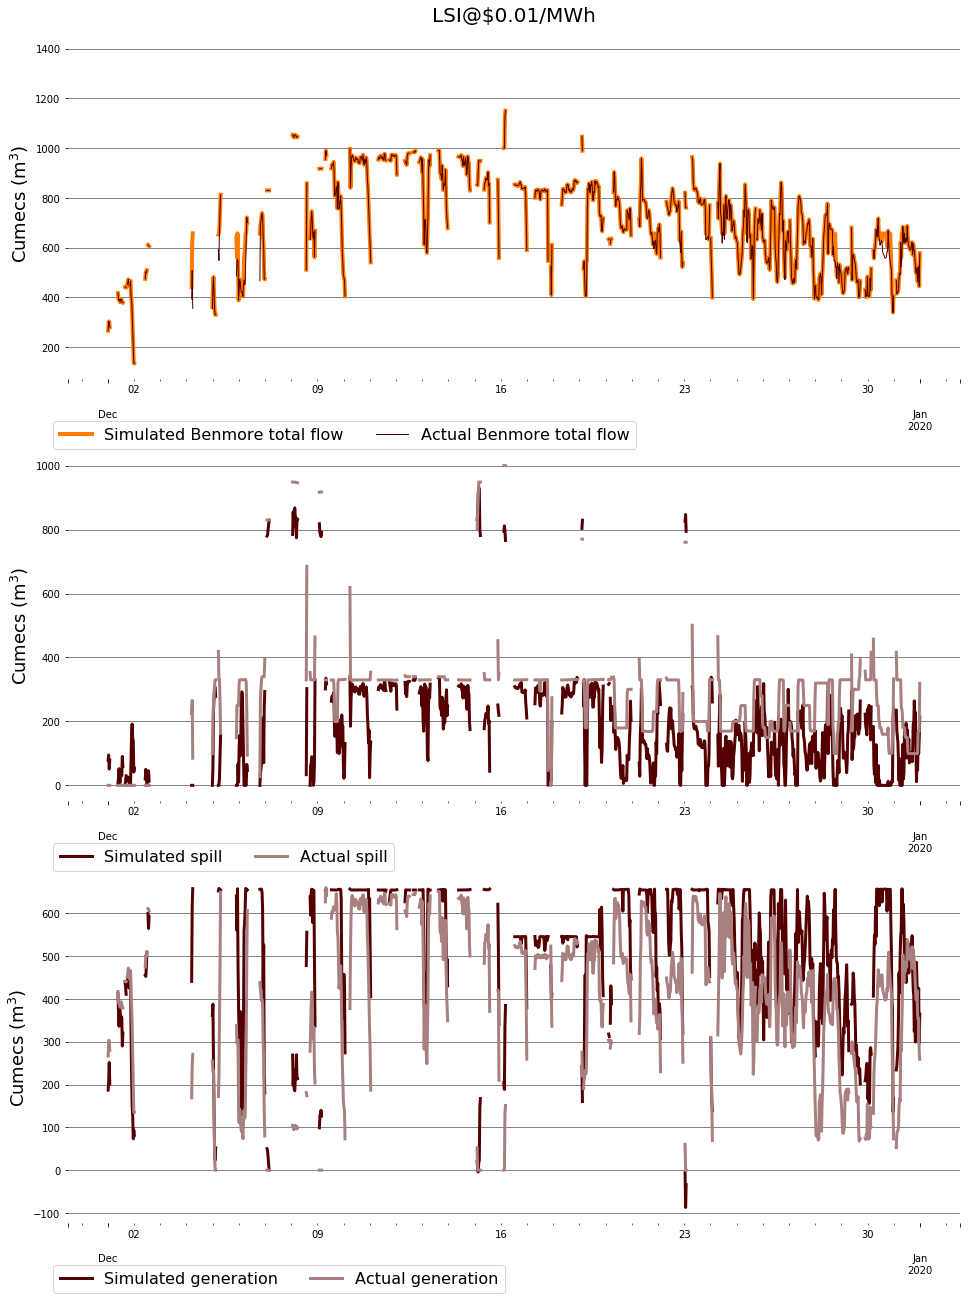

In [121]:
plot_ben_flows(BEN_CUMEC_new_001MWh, 'LSI@$0.01/MWh')

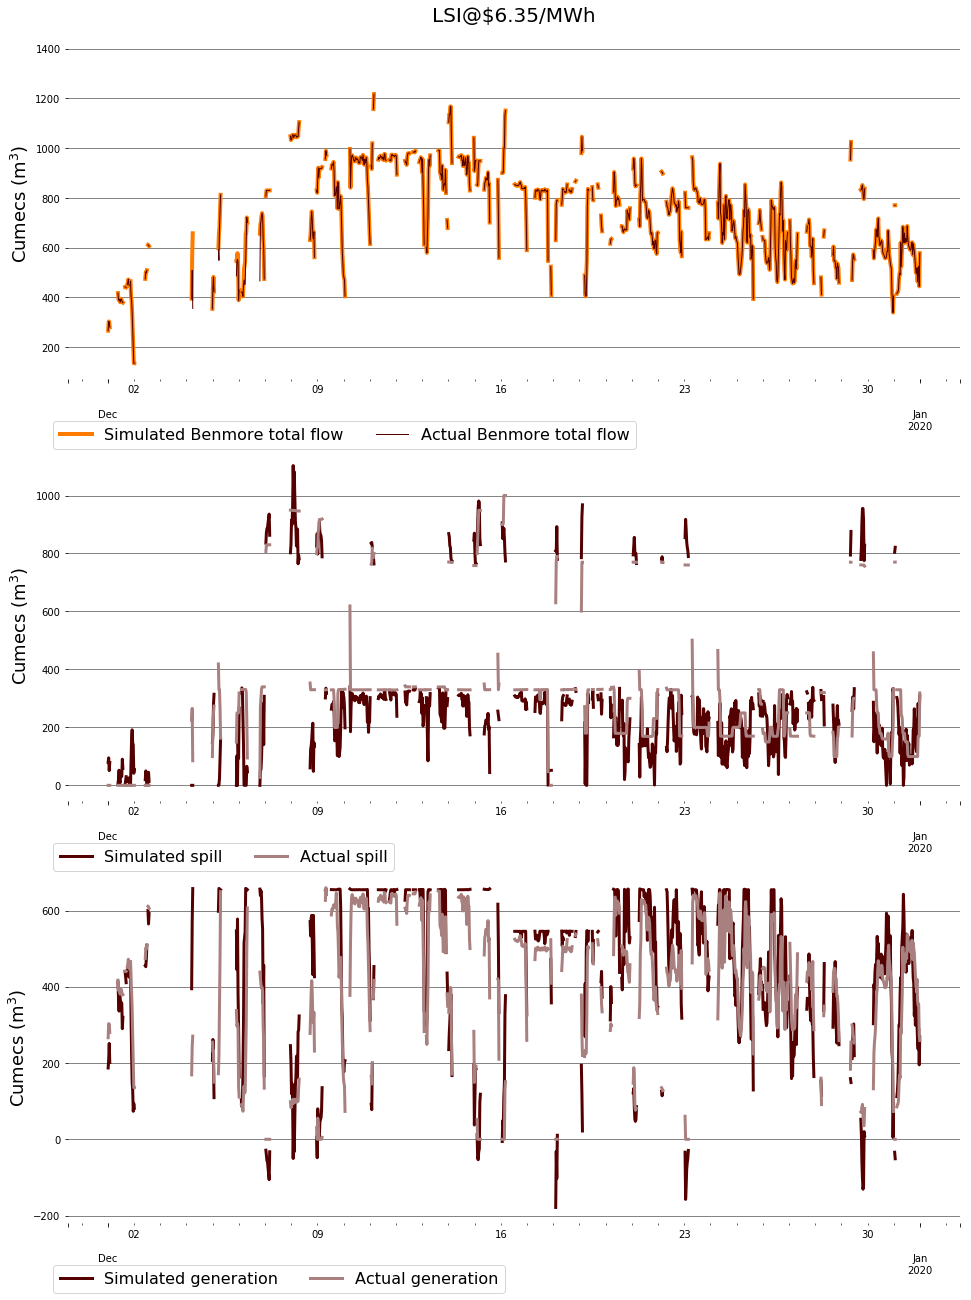

In [122]:
plot_ben_flows(BEN_CUMEC_new_6pt35, 'LSI@$6.35/MWh')

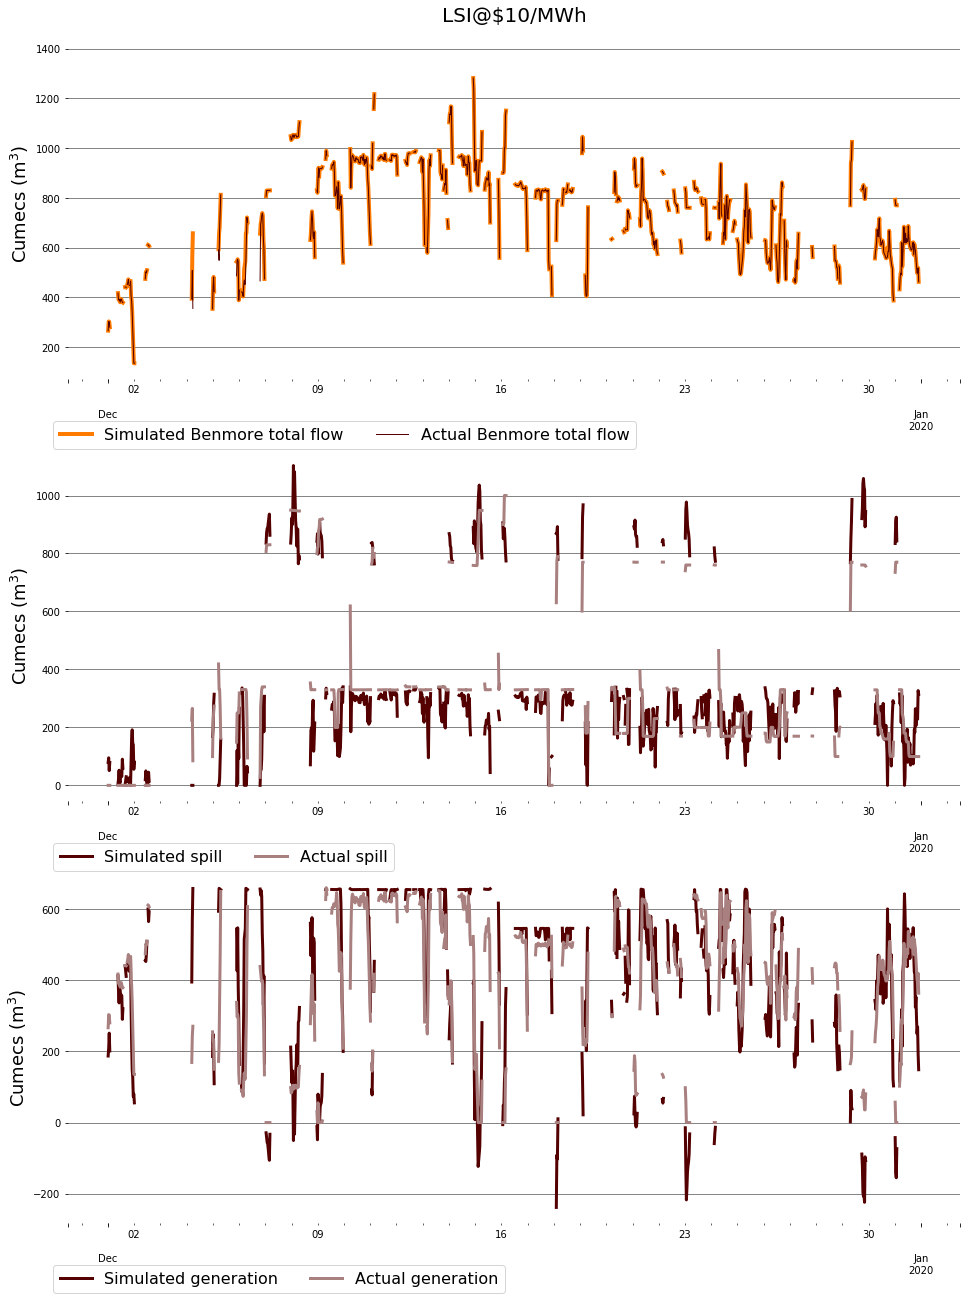

In [123]:
plot_ben_flows(BEN_CUMEC_new_10MWh, 'LSI@$10/MWh')

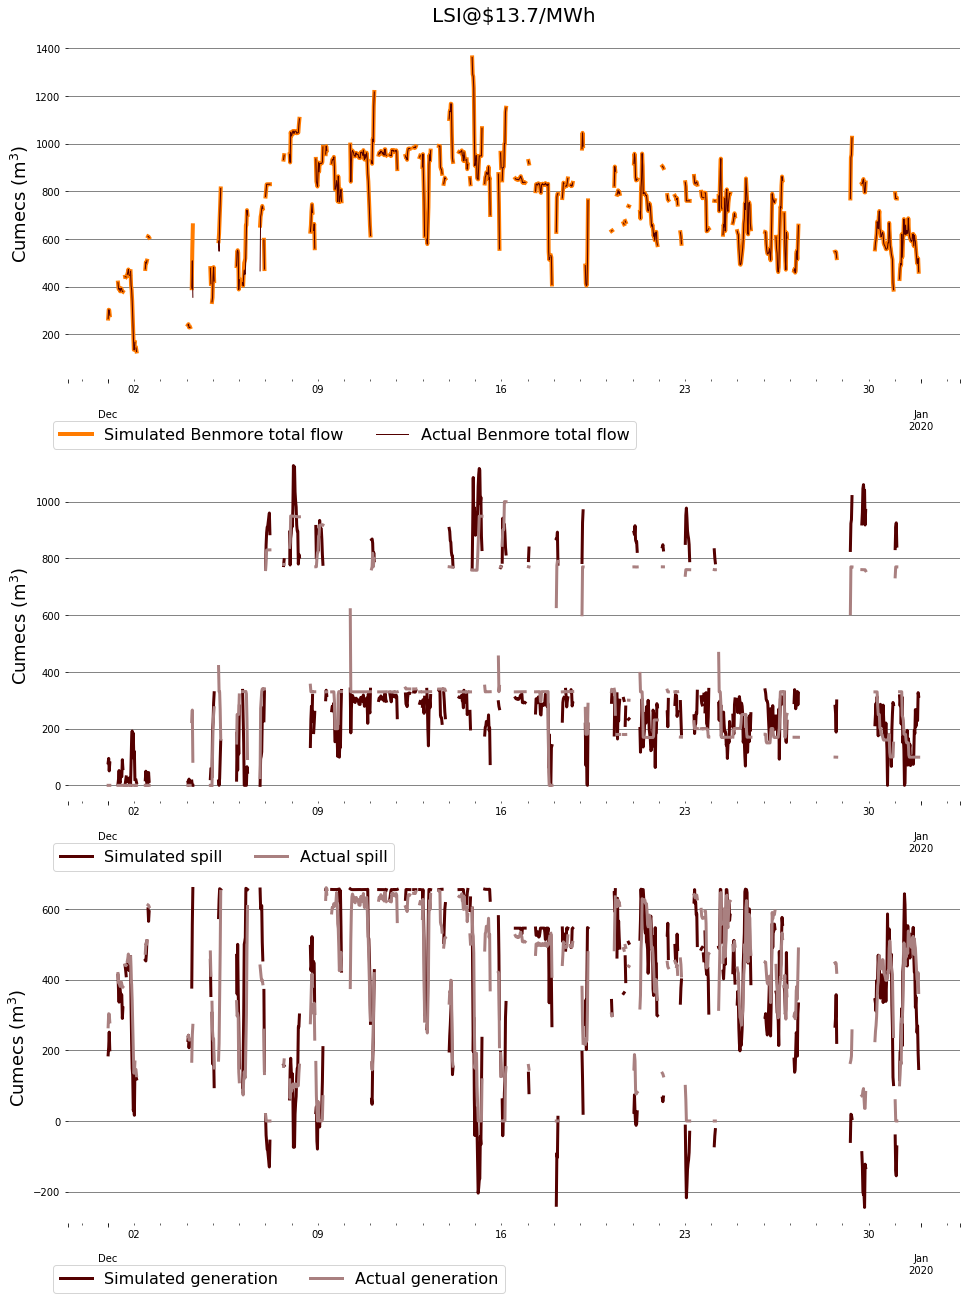

In [124]:
plot_ben_flows(BEN_CUMEC_new_13pt7, 'LSI@$13.7/MWh')


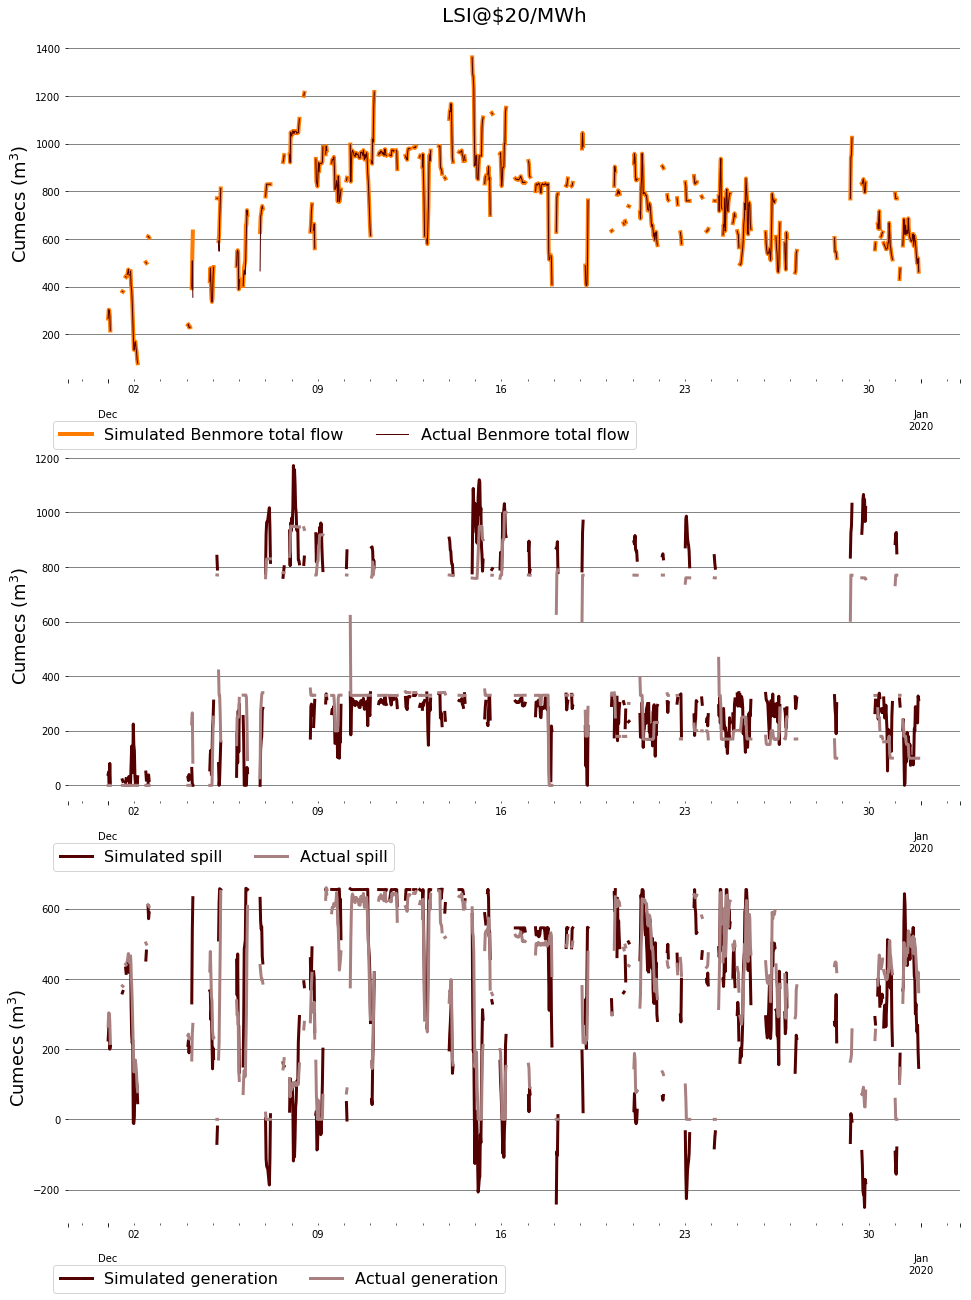

In [125]:
plot_ben_flows(BEN_CUMEC_new_20MWh, 'LSI@$20/MWh')

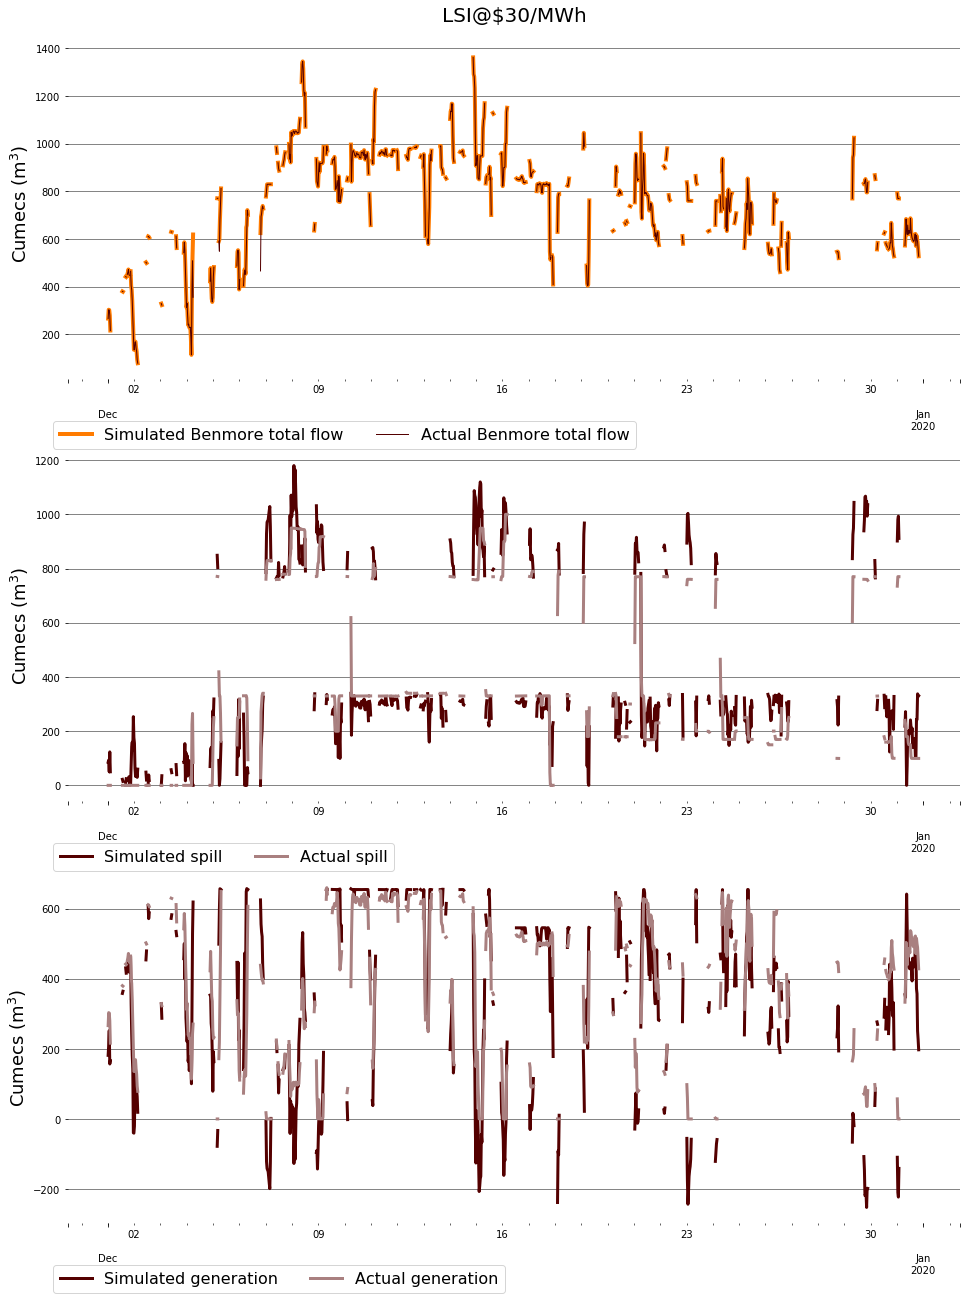

In [126]:
plot_ben_flows(BEN_CUMEC_new_30MWh, 'LSI@$30/MWh')

Text(2020-01-01 00:00:00, 6.778234077588554, '9MW / 6.7GWh')

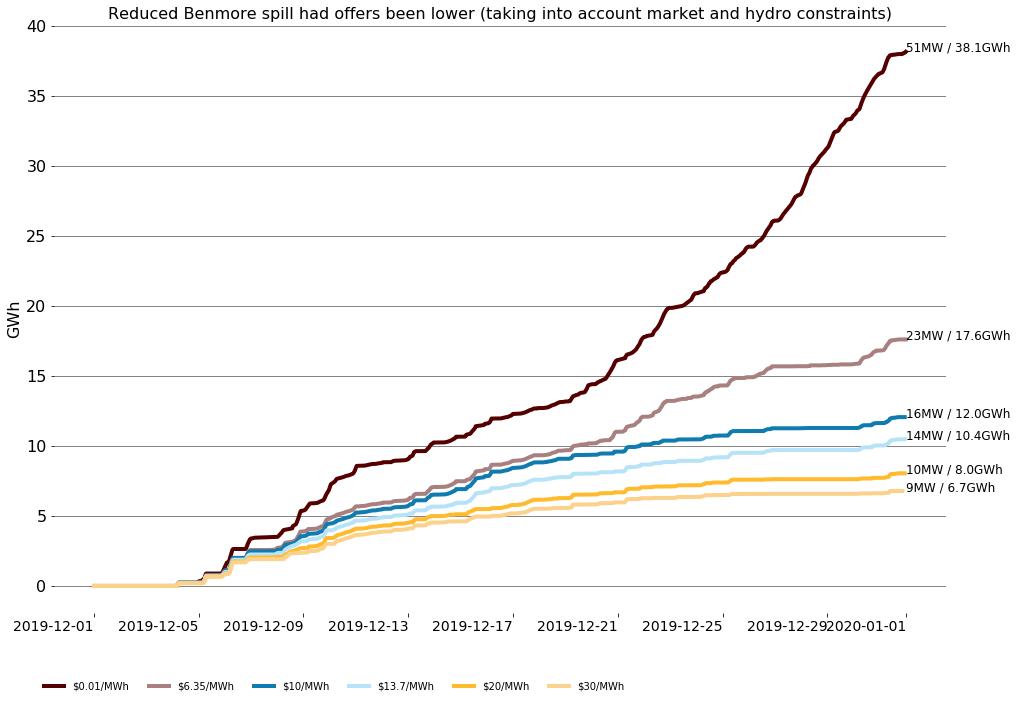

In [127]:
fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)

add_spill_001MWh.cumsum().plot(ax=ax, label='$0.01/MWh', lw=4, fontsize=16)
add_spill_6pt35.cumsum().plot(ax=ax, label='$6.35/MWh', lw=4)
add_spill_10MWh.cumsum().plot(ax=ax, label='$10/MWh', lw=4)
add_spill_13pt7.cumsum().plot(ax=ax, label='$13.7/MWh', lw=4)
add_spill_20MWh.cumsum().plot(ax=ax, label='$20/MWh', lw=4)
add_spill_30MWh.cumsum().plot(ax=ax, label='$30/MWh', lw=4)
legend_format(ax, cols=6)
plot_formatting(ax, fontsize=14)
ax.set_ylabel('GWh', fontsize=16)
ax.set_xlabel('')
ax.set_title('Reduced Benmore spill had offers been lower (taking into account market and hydro constraints)', fontsize=16)
ax.text(datetime(2020,1,1), add_spill_001MWh.cumsum()[-1], str(MW_spill_001MWh) + 'MW / ' + str(int(10*add_spill_001MWh.cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1), add_spill_6pt35.cumsum()[-1], str(MW_spill_6pt35) + 'MW / ' + str(int(10*add_spill_6pt35.cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1), add_spill_10MWh.cumsum()[-1], str(MW_spill_10MWh) + 'MW / ' + str(int(10*add_spill_10MWh.cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1), add_spill_13pt7.cumsum()[-1], str(MW_spill_13pt7) + 'MW / ' + str(int(10*add_spill_13pt7.cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1), add_spill_20MWh.cumsum()[-1], str(MW_spill_20MWh) + 'MW / ' + str(int(10*add_spill_20MWh.cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1), add_spill_30MWh.cumsum()[-1], str(MW_spill_30MWh) + 'MW / ' + str(int(10*add_spill_30MWh.cumsum()[-1])/10) + 'GWh', fontsize=12)


Text(2019-12-28 00:00:00, 6.580117286106407, '10.96MW / 6.5GWh')

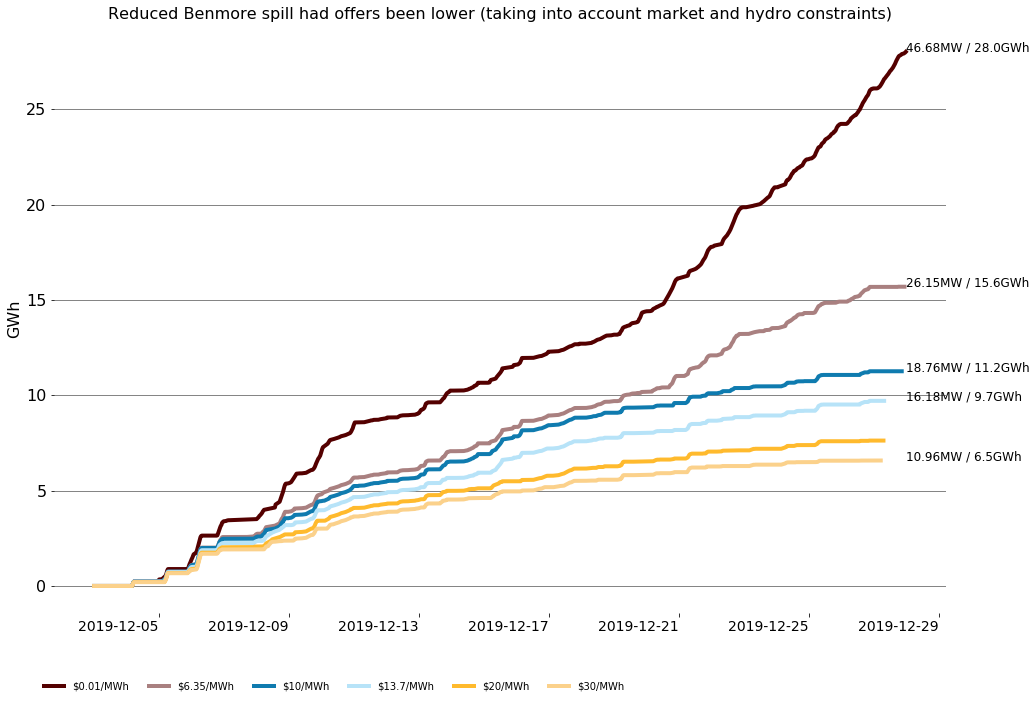

In [128]:

fig = plt.figure(1, figsize=[16,12])
ax = fig.add_subplot(111)

add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum().plot(ax=ax, label='$0.01/MWh', lw=4, fontsize=16)
add_spill_6pt35["2019/12/3": "2019/12/27"].cumsum().plot(ax=ax, label='$6.35/MWh', lw=4)
add_spill_10MWh["2019/12/3": "2019/12/27"].cumsum().plot(ax=ax, label='$10/MWh', lw=4)
add_spill_13pt7["2019/12/3": "2019/12/27"].cumsum().plot(ax=ax, label='$13.7/MWh', lw=4)
add_spill_20MWh["2019/12/3": "2019/12/27"].cumsum().plot(ax=ax, label='$20/MWh', lw=4)
add_spill_30MWh["2019/12/3": "2019/12/27"].cumsum().plot(ax=ax, label='$30/MWh', lw=4)
legend_format(ax, cols=6)
plot_formatting(ax, fontsize=14)
ax.set_ylabel('GWh', fontsize=16)
ax.set_xlabel('')
ax.set_title('Reduced Benmore spill had offers been lower (taking into account market and hydro constraints)', fontsize=16)
ax.text(datetime(2019,12,28), add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1], str(int(100*add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1]*1000/newhours)/100) + 'MW / ' + str(int(10*add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2019,12,28), add_spill_6pt35["2019/12/3": "2019/12/27"].cumsum()[-1], str(int(100*add_spill_6pt35["2019/12/3": "2019/12/27"].cumsum()[-1]*1000/newhours)/100) + 'MW / ' + str(int(10*add_spill_6pt35["2019/12/3": "2019/12/27"].cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2019,12,28), add_spill_10MWh["2019/12/3": "2019/12/27"].cumsum()[-1], str(int(100*add_spill_10MWh["2019/12/3": "2019/12/27"].cumsum()[-1]*1000/newhours)/100) + 'MW / ' + str(int(10*add_spill_10MWh["2019/12/3": "2019/12/27"].cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2019,12,28), add_spill_13pt7["2019/12/3": "2019/12/27"].cumsum()[-1], str(int(100*add_spill_13pt7["2019/12/3": "2019/12/27"].cumsum()[-1]*1000/newhours)/100) + 'MW / ' + str(int(10*add_spill_13pt7["2019/12/3": "2019/12/27"].cumsum()[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2019,12,28), add_spill_30MWh["2019/12/3": "2019/12/27"].cumsum()[-1], str(int(100*add_spill_30MWh["2019/12/3": "2019/12/27"].cumsum()[-1]*1000/newhours)/100) + 'MW / ' + str(int(10*add_spill_30MWh["2019/12/3": "2019/12/27"].cumsum()[-1])/10) + 'GWh', fontsize=12)

Estimating raw vSPD run results to determine what price LSI generation would have been dispatched at to match 46.7MW of reduced spill.

Text(2019-12-30 00:00:00, 38.64643321186064, '38.1GWh')

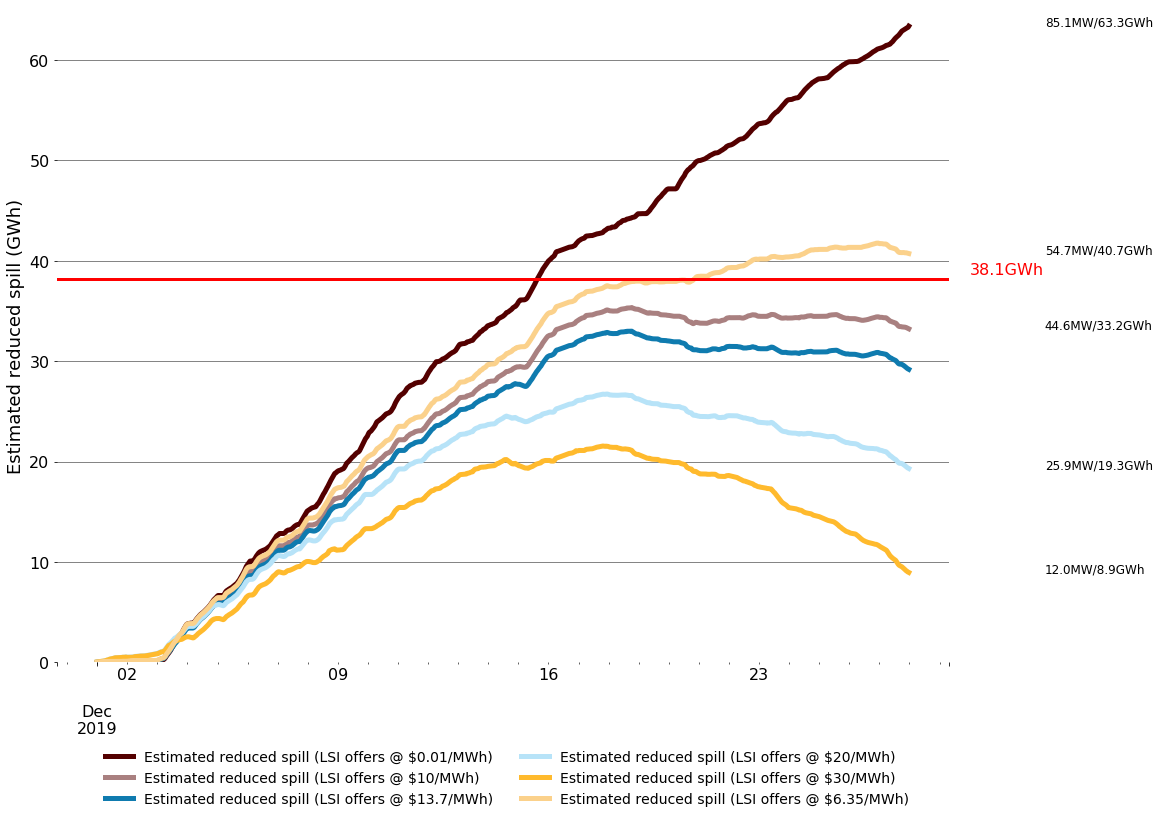

In [129]:
# old for all of DEC
fig = plt.figure(1, figsize=[16, 12])
ax = fig.add_subplot(111)
df["2019/12"].plot(lw=5, ax=ax, fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Estimated reduced spill (GWh)', fontsize=18)
ax.set_ylim([0, 65])
plot_formatting(ax)
legend_format(ax, fontsize=14, xpos=0.04, ypos=-.24, cols=2)
ax.text(datetime(2020,1,1,12), HVDC_diff_001MWh_cs[-1], str(int(10*HVDC_diff_001MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_001MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_6pt35_cs[-1], str(int(10*HVDC_diff_6pt35_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_6pt35_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_10MWh_cs[-1], str(int(10*HVDC_diff_10MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_10MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_20MWh_cs[-1], str(int(10*HVDC_diff_20MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_20MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_30MWh_cs[-1], str(int(10*HVDC_diff_30MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_30MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.axhline(add_spill_001MWh.cumsum()[-1], lw=3, color='r')
ax.text(datetime(2019,12,30), add_spill_001MWh.cumsum()[-1]+0.5, str(int(10*add_spill_001MWh.cumsum()[-1])/10) + 'GWh', fontsize=16, color='r' )


Text(2019-12-30 00:00:00, 28.51252226109416, '28.0GWh')

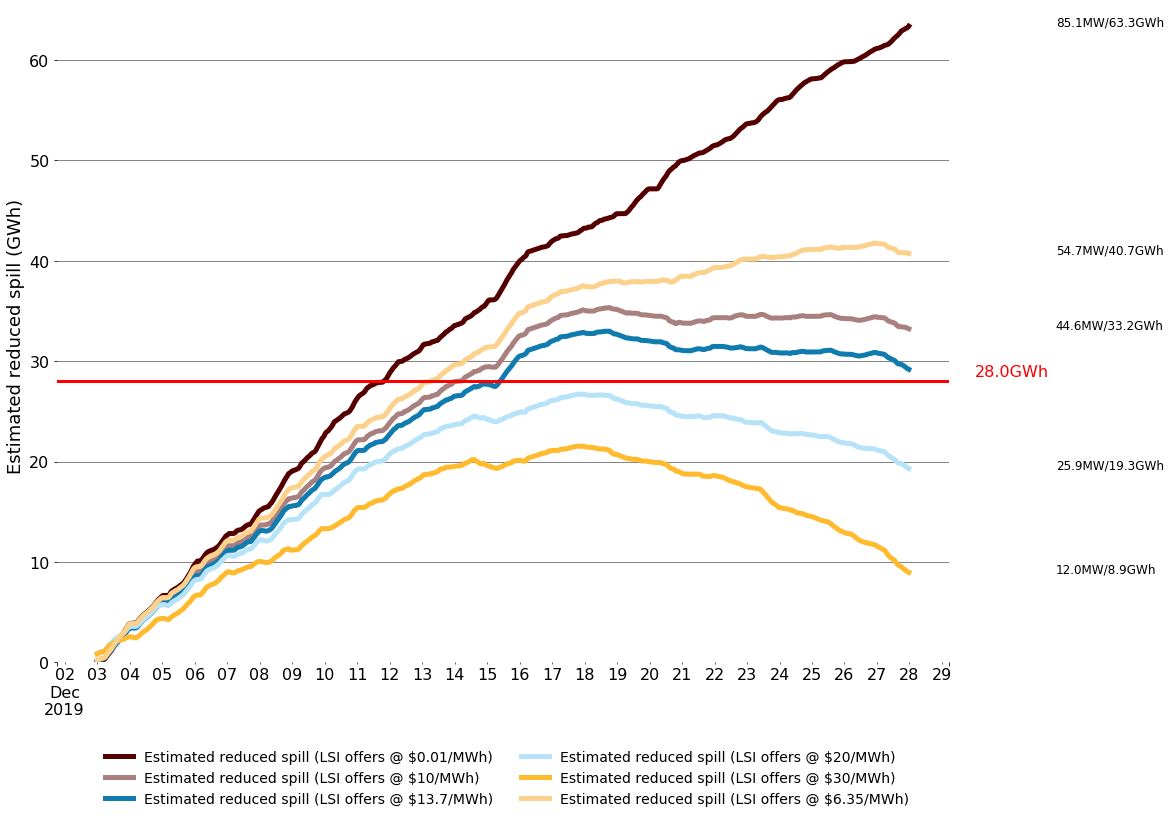

In [130]:
# New for UTS period from 2019/12/3 to 2019/12/27
fig = plt.figure(1, figsize=[16, 12])
ax = fig.add_subplot(111)
df["2019/12/3": "2019/12/27"].plot(lw=5, ax=ax, fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Estimated reduced spill (GWh)', fontsize=18)
ax.set_ylim([0, 65])
plot_formatting(ax)
legend_format(ax, fontsize=14, xpos=0.04, ypos=-.24, cols=2)
ax.text(datetime(2020,1,1,12), HVDC_diff_001MWh_cs[-1], str(int(10*HVDC_diff_001MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_001MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_6pt35_cs[-1], str(int(10*HVDC_diff_6pt35_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_6pt35_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_10MWh_cs[-1], str(int(10*HVDC_diff_10MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_10MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_20MWh_cs[-1], str(int(10*HVDC_diff_20MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_20MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.text(datetime(2020,1,1,12), HVDC_diff_30MWh_cs[-1], str(int(10*HVDC_diff_30MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_30MWh_cs[-1])/10) + 'GWh', fontsize=12)
#ax.text(datetime(2020,1,1,12), HVDC_diff_001MWh_cs[-1], str(int(10*HVDC_diff_001MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_001MWh_cs[-1])/10) + 'GWh', fontsize=12)
#ax.text(datetime(2020,1,1,12), HVDC_diff_6pt35_cs[-1], str(int(10*HVDC_diff_6pt35_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_6pt35_cs[-1])/10) + 'GWh', fontsize=12)
#ax.text(datetime(2020,1,1,12), HVDC_diff_10MWh_cs[-1], str(int(10*HVDC_diff_10MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_10MWh_cs[-1])/10) + 'GWh', fontsize=12)
#ax.text(datetime(2020,1,1,12), HVDC_diff_20MWh_cs[-1], str(int(10*HVDC_diff_20MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_20MWh_cs[-1])/10) + 'GWh', fontsize=12)
#ax.text(datetime(2020,1,1,12), HVDC_diff_30MWh_cs[-1], str(int(10*HVDC_diff_30MWh_cs[-1]*1000/24/31)/10) + 'MW/' + str(int(10*HVDC_diff_30MWh_cs[-1])/10) + 'GWh', fontsize=12)
ax.axhline(add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1], lw=3, color='r')
ax.text(datetime(2019,12,30), add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1]+0.5, str(int(10*add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1])/10) + 'GWh', fontsize=16, color='r' )

For all of December: On average, had LSI offers had been around \\$6.35/MWh we see around 53.7MW/39.9GWh of reduced SI spill throughout December 2019.  This is close to the result of the analysis above using the lower vSPD offer price of \\$0.01/MWh over all LSI generation and then dispatching this additional LSI generation at Benmore, but attempting to take into account the Benmore spillway 'no-go' flow constraints.  Doing this resulted in around 51MW/38.1GWh of additional spill at Benmore over December 2019.  

For the UTS period, starting on 2019/12/3 and ending on 2019/12/27, had offers been in the vicinity of \\$13/MWh to \\$15/MWh  we see around 46.7MW/28GWh of reduced SI spill through the UTS period.  

In the report...

We then used a trial and error approach to determine the offer price which would have been needed to clear this extra generation.  This resulted in an average of $13.7MWh over these trading periods. 

Text(28, 41.5, '40.7GWh')

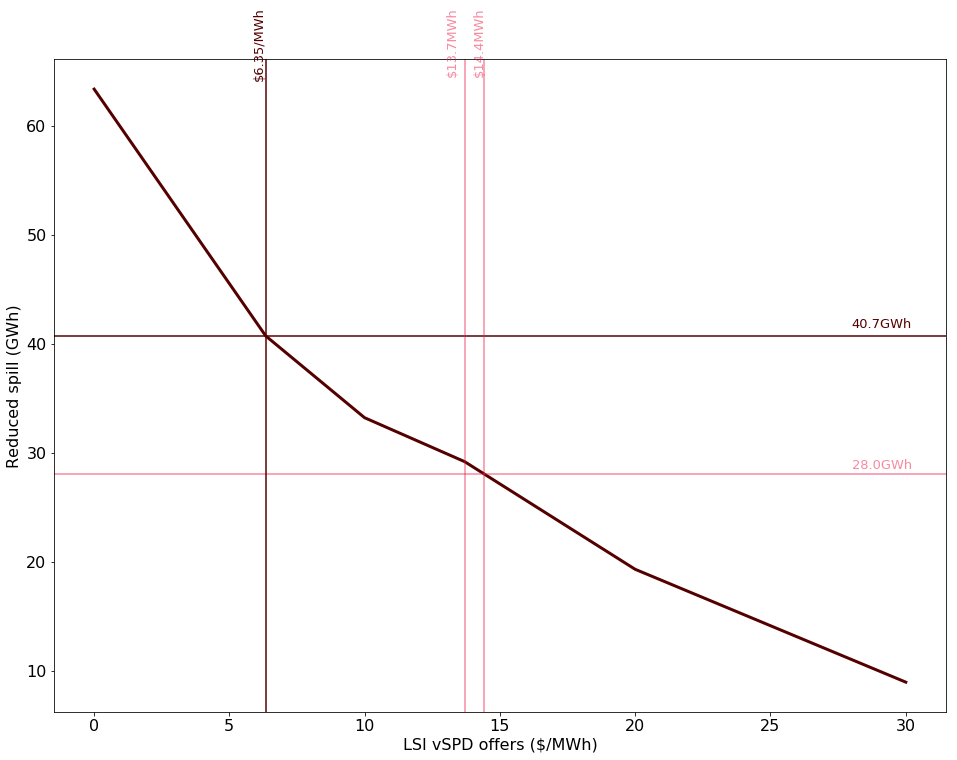

In [131]:
fig = plt.figure(1, figsize=[16, 12])
ax = fig.add_subplot(111)
proxy_spill =df["2019/12/3": "2019/12/27"].iloc[-1].sort_values()
proxy_spill.index=[30, 20, 13.7, 10, 6.35, 0.01]
proxy_spill.plot(ax=ax, lw=3, fontsize=16)
#ax.axhline(add_spill_001MWh.cumsum()[-1], color=c_p['rd1'], alpha=0.5)
ax.axhline(add_spill_001MWh["2019/12/03": "2019/12/27"].cumsum()[-1], color=c_p['rd1'], alpha=0.5)
ax.axhline(HVDC_diff_6pt35_cs[-1], )
ax.axvline(6.35)
ax.axvline(13.70, color=c_p['rd1'], alpha=0.5)
ax.axvline(14.40, color=c_p['rd1'], alpha=0.5)
ax.set_xlabel('LSI vSPD offers ($/MWh)', fontsize=16)
ax.set_ylabel('Reduced spill (GWh)', fontsize=16)

str(int(10*HVDC_diff_6pt35_cs[-1])/10) + 'GWh'

ax.text(13, 70, '$13.7MWh', rotation=90, fontsize=13, color=c_p['rd1'], alpha=0.5)
ax.text(14, 70, '$14.4MWh', rotation=90, fontsize=13, color=c_p['rd1'], alpha=0.5)
ax.text(5.86, 70, '$6.35/MWh', rotation=90, fontsize=13, color=c_p['br1'])
ax.text(28, 28.5, str(int(10*add_spill_001MWh["2019/12/3": "2019/12/27"].cumsum()[-1])/10) + 'GWh', rotation=0, fontsize=13, color=c_p['rd1'], alpha=0.5)
ax.text(28, 41.5, str(int(10*HVDC_diff_6pt35_cs[-1])/10) + 'GWh', rotation=0, fontsize=13, color=c_p['br1'])